# Prism V2 Demo - Local Agents

# Imports

In [69]:
%autoawait
import time
import datetime
import re
import qrcode
import uuid
import base64
import jwt
# https://pypi.org/project/termcolor/
from termcolor import colored,cprint
import json
import os
# from jwcrypto import jwk, jws,jwt
from jwcrypto.common import json_encode

from dotenv import load_dotenv
load_dotenv()
APIKEY = os.getenv('APIKEY')

from peerdid.peer_did import (
    resolve_peer_did,
)

from IPython import display
from base64 import b64decode

# display.Image(b64decode(base64_data)

IPython autoawait is `on`, and set to use `asyncio`


## Instantiate K8 Authenticated Agent Controllers

In [70]:
# from prism_agent_open_api_specification_client import AuthenticatedClient

# government_client_controller = AuthenticatedClient(base_url="https://agent-df56h.atalaprism.io/prism-agent", token=APIKEY)
# citizen_client_controller = AuthenticatedClient(base_url="https://agent-kj46b.atalaprism.io/prism-agent", token=APIKEY)
# university_store_client_controller = AuthenticatedClient(base_url="https://agent-sd98k.atalaprism.io/prism-agent", token=APIKEY)
# dapp_store_client_controller = AuthenticatedClient(base_url="https://agent-sd98k.atalaprism.io/prism-agent", token=APIKEY)
# employer_store_client_controller = AuthenticatedClient(base_url="https://agent-sd98k.atalaprism.io/prism-agent", token=APIKEY)

## Instantiate Localhost Agent Controllers

In [71]:
from prism_agent_open_api_specification_client import Client

government_client_controller = Client(base_url="http://host.docker.internal:8080/prism-agent")
citizen_client_controller = Client(base_url="http://host.docker.internal:8090/prism-agent")
university_client_controller = Client(base_url="http://host.docker.internal:9000/prism-agent")
employer_client_controller = Client(base_url="http://host.docker.internal:9010/prism-agent")
dapp_store_client_controller = Client(base_url="http://host.docker.internal:9030/prism-agent")

# Connections

## Import Connection Management Models and API Client

In [72]:
from prism_agent_open_api_specification_client.models import ConnectionCollection,Connection,ConnectionInvitation,CreateConnectionRequest,AcceptConnectionInvitationRequest
from prism_agent_open_api_specification_client.api.connections_management import get_connections,get_connection,create_connection,accept_connection_invitation
from prism_agent_open_api_specification_client.types import Response

## Connections Helper Functions

In [73]:
def create_invitation(inviter_client, label):
    # Create Invitation from Requestor
    conn_request = CreateConnectionRequest()
    conn_request.label = label
    invitation: Response[Connection] =  create_connection.sync(client=inviter_client,json_body=conn_request)
    # print("Connection ID\n",invitation.connection_id)
    # print("Invitation URL\n",issuer_invitation.invitation.invitation_url)
    invitationUrlbase64 = re.sub("^.*_oob=", "", invitation.invitation.invitation_url)
    # print("Invitation Base64\n",issuer_invitationUrlbase64)
    return invitation, invitationUrlbase64


def accept_connection(invitee_client, invitationUrlbase64):
    # Accept Invitation
    accept_conn_request = AcceptConnectionInvitationRequest(invitationUrlbase64)
    invitation: Response[ConnectionInvitation] =  accept_connection_invitation.sync(client=invitee_client,json_body=accept_conn_request)
    return invitation

async def check_connection_state(inviter_client, inviter_invitation, invitee_client, invitee_invitation):
    # Check Connection State
    inviter_conn: Response[Connection] =  get_connection.sync(client=inviter_client,connection_id=inviter_invitation.connection_id)
    invitee_conn: Response[Connection] =  get_connection.sync(client=invitee_client,connection_id=invitee_invitation.connection_id)
    # print(inviter_invitation.connection_id,invitee_invitation.connection_id)
    # print(inviter_conn.connection_id,invitee_conn.connection_id)

    while (inviter_conn.state != 'ConnectionResponseSent' and invitee_conn.state != 'ConnectionResponseReceived'):
        inviter_conn: Response[Connection] =  get_connection.sync(client=inviter_client,connection_id=inviter_invitation.connection_id)
        invitee_conn: Response[Connection] =  get_connection.sync(client=invitee_client,connection_id=invitee_invitation.connection_id)
        print("Inviter State: {} Invitee State: {} \n".format(inviter_conn.state,invitee_conn.state))
        time.sleep(3)

    print("Connection established between Inviter and Invitee!")
    
    return inviter_conn.state,invitee_conn.state

async def auto_connection(inviter_client, invitee_client, label):
    invitation,invitationUrlbase64 = create_invitation(inviter_client, label)
    # print("\n\n\n",invitation.connection_id)
    accept_invitation = accept_connection(invitee_client, invitationUrlbase64)
    await check_connection_state(inviter_client, invitation, invitee_client, accept_invitation)
    # print("\n\n\n", accept_invitation.connection_id)
    inviter_conn: Response[Connection] =  get_connection.sync(client=inviter_client,connection_id=invitation.connection_id)
    invitee_conn: Response[Connection] =  get_connection.sync(client=invitee_client,connection_id=accept_invitation.connection_id)
    return inviter_conn, invitee_conn


# Credentials

## Import Credential Management Models and API Client

In [74]:
from prism_agent_open_api_specification_client.models import IssueCredentialRecord, CreateIssueCredentialRecordRequest, CreateIssueCredentialRecordRequestClaims, IssueCredentialRecordCollection
from prism_agent_open_api_specification_client.api.issue_credentials_protocol import get_credential_record, get_credential_records, create_credential_offer,accept_credential_offer,issue_credential
from prism_agent_open_api_specification_client.types import Response, Unset

## Import DID Management Models and API Client

In [75]:
from prism_agent_open_api_specification_client.models import DID, DIDDocumentMetadata, DIDOperationResponse, DIDResponse, CreateManagedDidRequest, ListManagedDIDResponseInner, CreateManagedDIDResponse
from prism_agent_open_api_specification_client.api.did import get_did
from prism_agent_open_api_specification_client.api.did_registrar import create_managed_did,list_managed_did,publish_managed_did
from prism_agent_open_api_specification_client.types import Response

## Credential Helper Functions

In [76]:
def create_prism_did(did_client):
    data = {
    "documentTemplate": {
      "publicKeys": [
        {
          "id": "auth0",
          "purpose": "authentication"
        }
      ],
      "services": []
    }
  }
    new_did = CreateManagedDidRequest.from_dict(data)

    did: Response[CreateManagedDIDResponse] = create_managed_did.sync(client=did_client, json_body=new_did)
    return did

def get_credential_requests():
    # TODO - fix return 
    government_creds: Response[Credential] = get_credential_records.sync(client=government_client_controller)
    citizen_creds: Response[Credential] = get_credential_records.sync(client=citizen_client_controller)
    university_creds: Response[Credential] = get_credential_records.sync(client=university_client_controller)
    employer_creds: Response[Credential] = get_credential_records.sync(client=employer_client_controller)
    dapp_store_creds: Response[Credential] = get_credential_records.sync(client=dapp_store_client_controller)
    # print("Issuer Proofs:\n{}\n\nHolder Proofs:\n{}\n\nVerifier Proofs:\n{}".format(issuer_proofs, holder_proofs,verifier_proofs))
    return government_creds,citizen_creds,university_creds, employer_creds, dapp_store_creds

def create_credential(schema, schemaId, subjectDid):
    cred_claims = CreateIssueCredentialRecordRequestClaims()
    cred_claims = cred_claims.from_dict(schema)
    # print(cred_claims)
    credential = CreateIssueCredentialRecordRequest(subject_id=subjectDid, claims=cred_claims, schema_id=schemaId, validity_period=3600, automatic_issuance=False, await_confirmation=False)
    # print(credential_offer.to_dict())
    return credential

def send_credential_offer(issuer_client,credential):
    # Create Credential Offer
    cred_offer: Response[IssueCredentialRecord] = create_credential_offer.sync(client=issuer_client,json_body=credential)
    # print(cred_offer)
    return cred_offer

async def accept_credential(citizen_client, cred_record_id):
    # citizen_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=citizen_client,record_id=cred_record_id)
    # # print(citizen_creds)
    # # Check Credential State
    # while (citizen_creds.protocol_state != 'OfferReceived'):
    #     try:
    #             citizen_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=citizen_client,record_id=cred_record_id)
    #             time.sleep(1)
    #             # print(citizen_creds.protocol_state)
    #     except IndexError as e:
    #         pass

    # print(colored("Current state for Issuer Credential Record {} is {} and Holder Credential Record {} is {}".format(issuer_creds.items[0].record_id,issuer_creds.items[0].protocol_state,holder_creds.items[0].record_id,holder_creds.items[0].protocol_state), "magenta", attrs=["bold"]))
    # print(holder_creds.items[0].record_id)
    citizen_cred_record: Response[IssueCredentialRecord] = accept_credential_offer.sync(client=citizen_client, record_id=cred_record_id)
    # print(citizen_cred_record)
    return citizen_cred_record

def issue_credential_record(issuer_client, record_id):
    metro_cred_record: Response[IssueCredentialRecord] = issue_credential.sync(client=issuer_client, record_id=record_id)
    # print(metro_cred_record)
    return metro_cred_record

def check_credential_state(issuer_client, issuer_record_id, holder_client, holder_record_id):
    issuer_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=issuer_client, record_id=issuer_record_id)
    holder_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=holder_client, record_id=holder_record_id)

    print(colored("Current state for Issuer Credential Record {} is {} and Holder Credential Record {} is {}".format(issuer_creds.record_id,issuer_creds.protocol_state,holder_creds.record_id,holder_creds.protocol_state), "magenta", attrs=["bold"]))

    while (issuer_creds.protocol_state != 'CredentialSent' and holder_creds.protocol_state != 'CredentialReceived'):
        issuer_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=issuer_client, record_id=issuer_record_id)
        holder_creds: Response[IssueCredentialRecord] = get_credential_record.sync(client=holder_client, record_id=holder_record_id)
        print("Issuer State: {} Holder State: {} \n".format(issuer_creds.protocol_state,holder_creds.protocol_state))
        time.sleep(2)

    print(colored("Credential Record {} Issued to Holder! Continue with notebook".format(issuer_creds.record_id), "green", attrs=["bold"]))
    return issuer_creds, holder_creds



# Presentations

## Import Presentation Management Models and API Client

In [77]:
from prism_agent_open_api_specification_client.models import PresentationStatus, ErrorResponse, Proof, ProofRequestAux, PublicKeyJwk, RequestPresentationInput, RequestPresentationOutput, RequestPresentationAction
from prism_agent_open_api_specification_client.api.present_proof import get_all_presentation, request_presentation, update_presentation, get_presentation
from prism_agent_open_api_specification_client.types import Response

## Presentation Helper Functions

In [78]:
def get_all_presentation_requests():
    government_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=government_client_controller)
    citizen_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=citizen_client_controller)
    university_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=university_client_controller)
    employer_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=employer_client_controller)
    dapp_store_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=dapp_store_client_controller)
    # print("Issuer Proofs:\n{}\n\nHolder Proofs:\n{}\n\nVerifier Proofs:\n{}".format(issuer_proofs, holder_proofs,verifier_proofs))
    return government_proofs,citizen_proofs,university_proofs, employer_proofs, dapp_store_proofs

def get_client_presentation_requests(client):
    client_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=client)
    return client_proofs

def initiate_proof_request(verifier_client, verifier_connection_id):
    data = {
        "connectionId": verifier_connection_id, 
        "proofs": []
    }
    # print(data)

    # data = {
    #   "connectionId": verifier_invitation.connection_id, 
    #     "proofs": []
    # }
    proof_request = RequestPresentationInput.from_dict(data)
    # print(proof_request)

    verifier_proof_request: Response[RequestPresentationInput] = request_presentation.sync(client=verifier_client, json_body=proof_request)

    print(verifier_proof_request)
    return verifier_proof_request

def accept_proof(holder_client, holder_cred_id, holder_proof_id):
    from typing import Any, Dict, Optional, Union, cast

    data = {
      "action": "request-accept",
      # "proofId": [holder_creds.items[0].record_id]
        "proofId": [holder_cred_id]
    }

    proof_accept = RequestPresentationAction.from_dict(data)

    holder_proof_request: Response[Union[Any, ErrorResponse]] = update_presentation.sync(client=holder_client, json_body=proof_accept, id=holder_proof_id) #holder_proofs[0].presentation_id)

    print(holder_proof_request)
    return holder_proof_request

def check_presentation_status(holder_client,  verifier_client):
    # TODO - fix presentation record check to specific ID instead of all records
    holder_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=holder_client)
    verifier_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=verifier_client)
    # Check Proof Presentation State
    while (holder_proofs[0].status != 'PresentationSent' and verifier_proofs[0].status != 'PresentationVerified'):
        holder_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=holder_client)
        verifier_proofs: Response[PresentationStatus] = get_all_presentation.sync(client=verifier_client)
        print("Verifier State: {} Holder State: {} \n".format(verifier_proofs[0].status,holder_proofs[0].status))
        time.sleep(1)

    print("Proof Presentation completed between Verifier and Holder!")
    
def check_presentation_record_status(holder_client, holder_record_id,  verifier_client, verifier_record_id):
    # TODO - fix presentation record check to specific ID instead of all records
    holder_proof: Response[PresentationStatus] = get_presentation.sync(client=holder_client, id=holder_record_id)
    verifier_proof: Response[PresentationStatus] = get_presentation.sync(client=verifier_client, id=verifier_record_id)
    # Check Proof Presentation State
    while (holder_proof.status != 'PresentationVerified' and verifier_proof.status != 'PresentationSent'):
        holder_proof: Response[PresentationStatus] = get_presentation.sync(client=holder_client, id=holder_record_id)
        verifier_proof: Response[PresentationStatus] = get_presentation.sync(client=verifier_client, id=verifier_record_id)
        print("Verifier State: {} Holder State: {} \n".format(verifier_proof.status, holder_proof.status))
        time.sleep(1)

    print("Proof Presentation completed between Verifier and Holder!")
                                                                                         

# DIDs

## Import DID Management Models and API Client

In [79]:
from prism_agent_open_api_specification_client.models import DID, DIDDocumentMetadata, DIDOperationResponse, DIDResponse, CreateManagedDidRequest, ListManagedDIDResponseInner, CreateManagedDIDResponse
from prism_agent_open_api_specification_client.api.did import get_did
from prism_agent_open_api_specification_client.api.did_registrar import create_managed_did,list_managed_did,publish_managed_did
from prism_agent_open_api_specification_client.types import Response

# Demo Use Case

# Government Flow

## Make a Connection between Metropolgov.io and Citizen

In [80]:
metropolgov_conn, citizen_conn = await auto_connection(government_client_controller, citizen_client_controller, "Connection with Metropolgov.io")

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponseSent Invitee State: ConnectionResponseReceived 

Connection established between Inviter and Invitee!


## Metropolgov.io Issue Natural Person Credential to Citizen

In [81]:
# citizen_prism_did = create_prism_did(citizen_client_controller)
# print(citizen_prism_did)
citizen_id_schema = {
    "firstname": 'Wilmien',
    "lastname": 'Du Preez',
    "birthdate": '11/11/1999',
    "placeofbirth": "Pretoria",
    "gender": "Female",
    "idnumber": "19991111538708",
    "issuedate": "21/12/2022",
    "expiry_date": "23/12/2022",
    "photo": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQ4AAAC6CAMAAABoQ1NAAAAAjVBMVEX+/v4AAADt7e3////s7Oz9/f36+vr39/fv7+/y8vLp6ena2trl5eXV1dV4eHi3t7fKysrg4OCqqqpERERlZWXGxsaWlpaenp5UVFS/v7+AgIBsbGxOTk7Ozs6kpKSJiYkbGxs0NDQmJiYRERGxsbEiIiJoaGhTU1NeXl4vLy9JSUkYGBg8PDyNjY10dHQyCsxLAAAPMElEQVR4nO1da1/qPAzf1m1tuQoqIhxUvB31qN//4z29DNjWy9Jule08J28kPyGE/9o0SdM0QhEjhBNORDJUMFQyRDBYMumJQZlg0lwwuWQydBKWDlAyiSIpOrWKTsuiUyw+cxAtmINowUhhB6WHJDnxggNZRaMWSp9Z8j84/sFhgwMJoiknUmaoZEiZEa+ZaE6ZZHLB5JLJBIMlM0DJSYQpJyyJOjC4iXER1hfJUVKAF4l1qAAvEutQAZ4cS/KxyIFZPJYSI0bp6bEIJh2c5AhFSS8mbU8kR//g+AeHIxwVH1YVTSuiOZNWRFOz0jXJ3L4TQQh1K9lT50hqgzNOhWq5ymDJZCWGSoaqjBSW2SVTvg6yDyymY0YLLFb8TiS30flsfgfe3XxfvsRHery8ul9O8zN7NHLG/OykxShZvsVaelrfjFHxnf8PJ53S+ZUei8M42VxgSv4fcBA631vBEPR+l9LkfwAHnV42gyHofiQWm786hMP3QDA43Z3DlIoAhuBcEFEZ+RpXGBkbSYaqjPx8pgjDkw8HNOJ4f42BkrvSOfd2w1KtS1NmqqM0Tei1ExicZiPSLLlLnX/OScdzZzSYTd3l53fSQ8BBnz3QYPT8V8JBb/3QiOMVX2HOAYdtG6Kl7UA7XzTieMPwMEruWOeoYljLTMUWNzGaz1cY+uAPB8PDIrlbnX/E70jougUabIGhf1UIR1et0IjjG/oXOelk2hKNOJ4jreQhwkEoNE6x0EK1jgOFgy7boxG/89WiNyEc9jelSdoBGmK5dTSlPjpHRS2EwCsTrw+JBskU+/2SKR5LYn0sh8KKpGDa2tGCbmldcvc6d+CVVlwadZTmuBs04nhEOvNKTTqHd9LRV1dwfOPhxyyEdIVGHO/I4OGgNw6/d76x/vuD/gAcfn430DtOyDscjRlCC8OGQwFX3ipWAOgc4aCUX8DReGBPCKHbP+Z37POw2mIcNIRjwmdwOC6KYf1tGR7Ub5DCq38i98UCPmkRfgKjMStmLxsgxvdcUt8FrhdOuuWX1ekhL+DgX/Npehf3xQYMh9UyVmh3RIMPENO25RqfAQ7VabNk9C1wIApGY1NCg+Nh2p+aErCj6aEzg0OUNRS1EJIpyh8kU9RSSCY5MSxY4K9ZsMCZXDJZSVgSZfC58oIqcDA8DJHOFxaSA+lMonBrOHuxhcIxraLBAdHj8RiF9TsSR3PgMGlJ+qL9SSrdK2iwz+tdVLYcD9RJJ9DdBJHbUeDQ2+HZYOEAZ4zVqSK/51Hz3ic2LQYKB3A74UuLBpOgTTlfBIUjpCmFobFHBjj05nQT1JQ6lT84bX9lwP2EsQkNZj726tsfsW5jrSOdo7IX47LtCtgche3Zr4xoMFG6kpAdCaZzUCcdFM1+GqeKGB6aeqEVHWbMohnpKi0saDBZmnzJepBwJKAUum2qiOHxS/1MEhAO33moL8oqzUMytqBw2Ka0ThXxlZoSql0wnZNwKwu2WNJfh/9NGtBgSqufvkPhVpZwa7glLb4onvlNExoMD9Ugz+gQQzjNrC/ou4j8L5umChejBj6POJTOIZ108+CgxYLROFW4GI2cCRkcHPVM2Ot8MRpdbOQUkY/8DoAGE6RGPtcDhKOysGxHqAhk1vE7+8P/+RswVbggdR/vjgaDI5gpLScGN8dfjqKPaxShBXCqRNq4dkODmdKGo2KVs3IVJtMcQisJw+VotDQtEF/0EQt2lzA02ONT4HhDYXQmpOyGdXpEkZY308oZjcKwrGFThdtSZevqQRQiBzhWGc5Jx2ULuKn9dOZcjYBosDerlXZcg2HFLLS8df9dhwM/g9HQOWLjocFRLXO5Un48HI1IswX1HAwOJ8MLX4bIoqz+L4dfr8Khpgi/gugs+ncEosry2Bi4WuFQ61LXKJDWwap/KnmbR91GChgOdWvzkSbDCuGqj/QP7hYOHrUMykmvTXjSMRzjocFRLWkCOuRgOK6HBkc1BW7eSwHAockPPtPAcEizJEUXZkmKLsySFF1ijmYpEQ6xNEsnYdX91Ys2cGiyjCsaQmdR3Heywk7V/5HGpEcHYcmkqv68DRyaSt37ADoLJnIYS3APr37ACRq+auHQFEYxr39ITjqtzfeG7RQ7HJrdvPXA4Kg51vWQ1gkOTdnLflhw4FqCc9sGDk2V6UvJOnYKh5MPCw2HqgEcow9/ODTpH1kDFK5/B7SdYa4wxxPLgjl8RFkM3v1jOH1x6gR3rbNgumzBGB0fS6aUDFJ/OLR7vWPStc6CCeCVJlhz4AueC1Tg0NbqTklYr7RDOHSHWHb+cGjPS+0GAwfV1YT5u6VIW7r8k3AU89Ak2lJYwaeKtsUPbANSC4e2dPmiDoe/zmUmOnQgzPP81MFQYQ7tDPMTQyVDqwzF+tpabz9MV+DB4aDd6XwEIO+4BSNCpjZpr95w6IuIdn3v38HgJhfGOmPv5LEmccxpGsgrbQ2HzBFQTG43lUOONV/SN1tqKMcc9xEOKpuwkvHzrKlHh2960FCOueghHOn9+u3tEtbl6NYPDmQoxwwFRxtTmpAluOOTZ8bD1GFrFCqEc1pos8qilWUoW+pOlT+qQeibJxyGMzEL+EJb0TlrWGjbumGYzOvLycul5uD4g99GHPqtReNpFMgN08EhFAE7vJSOV6VthM+tvoLSK4gzOGHxS+iNhRaiCaWYXtxttm9Xm7ubreGcue74XzMchkruzx7DkU4nwlJlo/n9Xq8+J0CJsYLGSHccjtFVMDgKwxt5p1ISwsfDn+bmA867C/rDcJw2Bzi6Tv90kBzMoV0p3PBAluNSd3nnCU2ZHOwihAN37XWoCLOcw2d03V3Y2XkI59ClA44Hym3dHUZ93mexndWoETQrZjSigv5EvYZjYlG9RpbxUcoBMN98bcGYl971Fw6X4WG2p4gc6vgRuon3S/N5GFHFfM4QrqmdIbxvidn/QHQW739vt9urX03dtXZd6KwtaEgK8OS7JXjFuyV4xbulS1NiKqUj2KVD670hM8aWKKBNHpEOdNaWuxzggIwlm4fn0vj7zZQpRIZUYI0ucTc6KzOru30WNAb3j9uzkMOIBwW0QFmFO97TFRxs6VvuYXD8pg989mvRuGCGYbR8ta2ysh9S3+HgJmn6vHldX/5q6NvxC+Wvsjl+HQw8i7diSkd0sTPeyfAZ8qSkiw/btAwVZ3OThtGBuI34WFQBYdySp1SlkrbV6i7gOdqmonUPyhrsIc8TosVlPJug0xk5hJ9f4vvS9oMp8xPHabhOjJ1X/zCB2d4Oh9igRGj+J/59W7TcRNNvfhtLebygzPDxLe1aZ3Q6wBE5TK0mD08qEFlaSgpaHebD9W82VG7mt8+bp/h9SeuTx7DGHNqZ9NdJl6LT1d3y+aY5+XEI4/hzXIrugperMVJMq65EjtEbHUgLRuiNNKUOJnLUykFVJ83xajk4graN14iu5N2TEqMTLQyBFI3vQHDUthiMLqq2LeWWdtCCsaRzDY6mGyiNR3R1d1vaElinHwRNeehs0NOEFl0Xu9K5eqzYxfA2r+EUgAd0t1ZzfpbbHcfF4ryHvwzFP+XnCyxtQPVSXU5X4ny1izk4c6kcvra0suYE3bvWVQy+y82EAcGR0JF9qYUWeui6w4zdF4tzw5GQbGzJ68XXwLmiKey4zYLDEcAsMWFT864AcG9ScwLu4zZ197t70YIRZztTM2vgOqv3Oj5WO4plLUa/WjDaXJqE0nS3MhQGfYLgMAZw8dPV3ah4xl3q3L2TLkWzETeZf1tSfKCF1n7N4Of9BeVXxnelcyg42EMbPTf0igedqW32b9erixQzZ7SvcPCr7cc3zZeegfYlTdF9hR62yzEWIc/ZWzDWW6ESnN7O7BnfgiBlQFqXVEufXzzJ2Fn71m5Wljy7Bl+nAKkh1B9iMQkco361YKSLV7j2T4BON9rwzUwzkvUnhCOO9wI21xCihly8Qnspsw9OOiHgqxQkNfcn0DVlaCCRYusBHGRki1B01OymI4e5V8ajB3CMnO8TrXcRU9HwuWnwgSl0/hAOu44NgJsOr70r02XULuwUptT36pdMXv2CHep+jtRUnu5STFSiGYbprL2uRr6t+H7fdoZ+t9s3uOkIOdytV6ZnDNE5nJNOHGrkStTgpsNd0ho9kfPGLBh+s1eZGtx0J5e0QpuzwkG9TB6vaLDD4X/3tbzy+jyHvxLvO7utcKCRNxq81bhdZ/vS2aoFY+45OOI4teEBvMhET7ftaj9aVf/4WY64wU03XhkIoT1vznieEM5vWeFka1BgrvoBEe83dx4n3f+Wapub7ueSHumdkvPAoXa0AdPeBofDFbY6eqZngYO61BnXyeymowh8UllPlwA4VLf7AEfRrke8zsTrpIBDMkJ0hCVTiJYfaSoBs5Hlti/bLTcguiZGnW39ioqvL1lhp+p/nyD8SGY33XSsGk6vbicWujn85VSTr5DposDIVCDnQhNq0Dmgk67vUASltQmONi7pgb7wj8OBcvil3Rp6MNbHuWWhtfQ0Ij8OB/RyVQOZ3HRD9aQble9v+aEQDlIjaCFDW7WWLmlBnyTxC+GOLRiNm1SGHSvtXbEOZHDT2xnoI+0ywy5bmdHt0pXdMMCtmXIypQnR9NFzopkBjjbOzIm2CKk6QzahPb1SSP2olfTZdN01X16U1uEI66TTlnPFUPTS1kAfafWjcLSeK4abRlsEyVV6ilB3cFRshwoH7QIOrZsOu7MVQtfIz3YIu0oKw0oEk6sMlsyxZA+3XgF0bnqLhFKNrnCm6AwpYPH2O9rOcl3RC4IdAGmmL0p+uH+HuRENjB41RS+WWzmdaI7Jj++zdO+mOxe56Olh8vMhHBNNJ/oWZ0DaIYU6cUnf8Jl24Uj96gAnEncOY9GjiG+kp+lo5FHkotASoTPtwjFvbNwyz9sxva9wk84NprTpqFhePiqmHJyL0GjMaTESNG5gJuL1hL+cTieCFlNBBSPfJj+ycJecY9qsc+3gHC0B4N+C8VQbJkQX40qKLsaVhLPMyCdRHN2T/8jLDFaFOUmG6qxm0sN10feZtD2RHPIu639w/AVwFIY3irpuZ5gOUHJUJMokUQcGNzEuwvoiOdQFrKljYUU/JIe7rbgv5qAXV139g+PvhkNX/nAQHVlFRw1K91jysZ1JYkU6KYtOypsySdmjT4oVTrx2KqzoiWTyH0OmNgTTsTIxAAAAAElFTkSuQmCC",
  }

metropolgov_cred = create_credential(citizen_id_schema, "schema:12345:gov", metropolgov_conn.their_did)
metropolgov_cred_offer = send_credential_offer(government_client_controller, metropolgov_cred)
metropolgov_record_id = metropolgov_cred_offer.record_id
print(metropolgov_record_id)
time.sleep(2)

29dd1804-374a-4311-b5cd-32f9b30a6cd3


In [89]:
citizen_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
citizen_gov_record_id = citizen_creds.items[0].record_id
print(citizen_gov_record_id, ' ', citizen_creds.items[0].protocol_state)

1722d115-99d1-4277-b8be-41106ca45826   RequestSent


IssueCredentialRecord(subject_id='did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0', claims=CreateIssueCredentialRecordRequestClaims(additional_properties={'photo': '', 'firstname': 'Wilmien', 'idnumber': '19991111538708', 'placeofbirth': 'Pretoria', 'lastname': 'Du Preez', 'birthdate': '11/11/1999', 'issuedate': '21/12/2022', 'expiry_date': '23/12/2022', 'gender': 'Female'}), record_id='1722d115-99d1-4277-b8be-41106ca45826', created_at=datetime.datetime(2022, 12, 21, 10, 39, 27, tzinfo=tzutc()), role=<IssueCredentialRecordAllOfRole.HOLDER: 'Holder'>, protocol_state=<IssueCredentialRecordAllOfProtocolState.REQUESTPENDING: 'RequestPending'>, schema_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, validity_period=<prism_agent_open_api_specification_client.types.Unset object at 0x7
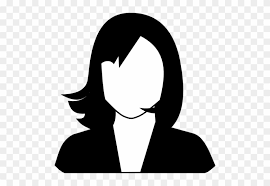

In [83]:
citizen_cred = await accept_credential(citizen_client_controller, citizen_gov_record_id)
print(citizen_cred)
time.sleep(2)

In [90]:
time.sleep(3)
metro_cred_record = issue_credential_record(government_client_controller, metropolgov_cred_offer.record_id)

metropolgov_credentials, citizen_credential = check_credential_state(government_client_controller, metropolgov_record_id, citizen_client_controller, citizen_gov_record_id)


Current state for Issuer Credential Record 29dd1804-374a-4311-b5cd-32f9b30a6cd3 is CredentialPending and Holder Credential Record 1722d115-99d1-4277-b8be-41106ca45826 is RequestSent
Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: CredentialReceived 

Credential Record 29dd1804-374a-4311-b5cd-32f9b30a6cd3 Issued to Holder! Continue with notebook


## JWT Verify

### List DIDs in Wallet

In [91]:
governance_dids: Response[ListManagedDIDResponseInner] = list_managed_did.sync(client=government_client_controller)
print(governance_dids)

[ListManagedDIDResponseInner(did='did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', status=<ListManagedDIDResponseInnerStatus.CREATED: 'CREATED'>, long_form_did='did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESID6anbkbZva0-doiu5yXqGPZXZwJrDWIyvG62VeusiFlGiB_Dudim4wifTwXjrd2qFTwEQdd8Bl8ylWy5dE3fFw1lhJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDECh1IHCnaZsmQfmwHwClP1cQ_pwSPXdDg8Q8WpIH_oxogOMv8VBbW-IwqxhsCacDtkZItX236PQ7z9jQI3CbQd_Y', additional_properties={})]


### Resolve DID

In [92]:
governance_resolved_did: Response[DIDResponse] = get_did.sync(client=government_client_controller, did_ref=governance_dids[0].long_form_did)
print(governance_resolved_did.to_dict())

{'did': {'id': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'controller': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'verificationMethod': [], 'authentication': [{'id': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41#issuing', 'type': 'EcdsaSecp256k1VerificationKey2019', 'controller': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'publicKeyJwk': {'kty': 'EC', 'crv': 'secp256k1', 'x': 'PpqduRtm9rT52iK7nJeoY9ldnAmsNYjK8brZV66yIWU', 'y': 'fw7nYpuMIn08F463dqhU8BEHXfAZfMpVsuXRN3xcNZY'}}], 'assertionMethod': [], 'keyAgreement': [], 'capabilityInvocation': [], 'service': []}, 'metadata': {'deactivated': False}}


### Decode JWT in Credential

{'iss': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESID6anbkbZva0-doiu5yXqGPZXZwJrDWIyvG62VeusiFlGiB_Dudim4wifTwXjrd2qFTwEQdd8Bl8ylWy5dE3fFw1lhJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDECh1IHCnaZsmQfmwHwClP1cQ_pwSPXdDg8Q8WpIH_oxogOMv8VBbW-IwqxhsCacDtkZItX236PQ7z9jQI3CbQd_Y',
 'sub': 'did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0',
 'nbf': 1671619199,
 'exp': 1671622799,
 'vc': {'credentialSubject': {'firstname': 'Wilmien',
   'birthdate': '11/11/1999',
   'gender': 'Female',
   'idnumber': '19991111538708',
   'expiry_date': '23/12/2022',
   'photo': '',
   'id': 'did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY
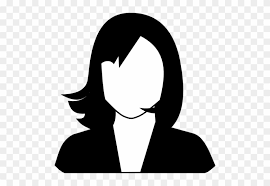

In [93]:
token = citizen_credential.jwt_credential
# print(token)
jsondata = base64.urlsafe_b64decode(token)
# print(jsondata)
b64decoded_token = json.loads(jsondata.decode())
jwk = governance_resolved_did.did.authentication[0].public_key_jwk
# print(jwk)
# print(json.dumps(jwk.to_dict()))
pubKey = jwt.algorithms.ECAlgorithm.from_jwk(json.dumps(jwk.to_dict()))
jwt.decode(b64decoded_token , key = pubKey, algorithms=["ES256K"])

In [94]:
b64decoded_token = b64decoded_token + 'a'
jwt.decode(b64decoded_token , key = pubKey, algorithms=["ES256K"])

InvalidSignatureError: Signature verification failed

# University Flow

## Make a Connection between University and Citizen

In [95]:
uni_conn, citizen_uni_conn = await auto_connection(university_client_controller, citizen_client_controller, "Connection with University of I&T")

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponseSent Invitee State: ConnectionRequestSent 

Connection established between Inviter and Invitee!


## Citizen Present Natural Person Proof to University of Innovation and Technology

In [96]:
uni_proof_request = initiate_proof_request(university_client_controller, uni_conn.connection_id)
print(uni_proof_request.presentation_id)

RequestPresentationOutput(presentation_id='e965e910-91a9-444c-8532-5aecb5e5f758', additional_properties={})
e965e910-91a9-444c-8532-5aecb5e5f758


In [97]:
government_proofs,citizen_proofs,university_proofs, employer_proofs, dapp_store_proofs = get_all_presentation_requests()
print(government_proofs,citizen_proofs,university_proofs, employer_proofs, dapp_store_proofs)

[] [PresentationStatus(presentation_id='e225f594-8493-4b3f-b48c-6019630d2f6b', status='RequestReceived', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})] [PresentationStatus(presentation_id='e965e910-91a9-444c-8532-5aecb5e5f758', status='RequestPending', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})] [] []


In [98]:
print(citizen_proofs[0].presentation_id)
print(university_proofs[0].presentation_id)

e225f594-8493-4b3f-b48c-6019630d2f6b
e965e910-91a9-444c-8532-5aecb5e5f758


In [99]:
citizen_uni_proof_request = accept_proof(citizen_client_controller, citizen_gov_record_id, citizen_proofs[0].presentation_id)

None


In [100]:
check_presentation_record_status(university_client_controller, university_proofs[0].presentation_id, citizen_client_controller, citizen_proofs[0].presentation_id)

Verifier State: PresentationPending Holder State: PresentationReceived 

Verifier State: PresentationSent Holder State: PresentationReceived 

Proof Presentation completed between Verifier and Holder!


## JWT Verify

### Decode JWT in Credential

In [108]:
citizen_proofs = get_client_presentation_requests(citizen_client_controller)

In [109]:
# print(citizen_proofs)

In [110]:
# print(citizen_proofs[0].data[0])

In [111]:
token = citizen_proofs[0].data[0]

try:
    jwt_gov_decoded_presentation = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_gov_decoded_presentation, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)    

{
  "iss": "did:prism:6979f4bb-a866-4c85-9ee7-b8e7a93e607f",
  "vp": {
    "@context": [
      "https://www.w3.org/2018/presentations/v1"
    ],
    "type": [
      "VerifiablePresentation"
    ],
    "verifiableCredential": [
      "eyJhbGciOiJFUzI1NksifQ.eyJpc3MiOiJkaWQ6cHJpc206ZGI3NTA3MTRiZDc5ZjY5NmIyMjhmNzhhNTE0YmFjMzkyOTJhZWI4MWYxYzAwYzgwNTc2MmQzMzQ3MjEzN2I0MTpDcjhCQ3J3QkVsd0tCMmx6YzNWcGJtY1FCRUpQQ2dselpXTndNalUyYXpFU0lENmFuYmtiWnZhMC1kb2l1NXlYcUdQWlhad0pyRFdJeXZHNjJWZXVzaUZsR2lCX0R1ZGltNHdpZlR3WGpyZDJxRlR3RVFkZDhCbDh5bFd5NWRFM2ZGdzFsaEpjQ2dkdFlYTjBaWEl3RUFGQ1R3b0pjMlZqY0RJMU5tc3hFaURFQ2gxSUhDbmFac21RZm13SHdDbFAxY1FfcHdTUFhkRGc4UThXcElIX294b2dPTXY4VkJiVy1Jd3F4aHNDYWNEdGtaSXRYMjM2UFE3ejlqUUkzQ2JRZF9ZIiwic3ViIjoiZGlkOnBlZXI6Mi5FejZMU2NmSDMzWFoxaFRwS0ZYZVJOTDJjWnFQQUZkRnBia2tqN0xqdWFWamRTaE4zLlZ6Nk1rb2FxaENkYnJzQWphV2JrNmRXOUF4WEJ5amloaDFoVXNvc3FLaFRXaDYzRmsuU2V5SjBJam9pWkcwaUxDSnpJam9pYUhSMGNEb3ZMMmh2YzNRdVpHOWphMlZ5TG1sdWRHVnlibUZzT2pnd09UQXZaR2xrWTI5dGJTSXNJbklpT2x0ZExDSmhJanBiSW1

{
  "iss": "did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESID6anbkbZva0-doiu5yXqGPZXZwJrDWIyvG62VeusiFlGiB_Dudim4wifTwXjrd2qFTwEQdd8Bl8ylWy5dE3fFw1lhJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDECh1IHCnaZsmQfmwHwClP1cQ_pwSPXdDg8Q8WpIH_oxogOMv8VBbW-IwqxhsCacDtkZItX236PQ7z9jQI3CbQd_Y",
  "sub": "did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
  "nbf": 1671619199,
  "exp": 1671622799,
  "vc": {
    "credentialSubject": {
      "firstname": "Wilmien",
      "birthdate": "11/11/1999",
      "gender": "Female",
      "idnumber": "19991111538708",
      "expiry_date": "23/12/2022",
      "photo": "",
      "id": "did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hv
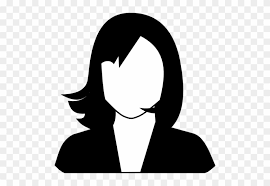

In [112]:
token = jwt_gov_decoded_presentation['vp']['verifiableCredential'][0]

try:
    jwt_gov_decoded_vc = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_gov_decoded_vc, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)
    


In [113]:
jwt_nbf = jwt_decoded_id_token['nbf']
jwt_exp = jwt_decoded_id_token['exp']
print('NBF epoch: {} EXP epoch: {}'.format(jwt_nbf,jwt_exp))

human_jwt_nbf = datetime.datetime.fromtimestamp(jwt_nbf)
human_jwt_exp = datetime.datetime.fromtimestamp(jwt_exp)
print('NBF: {} EXP: {}'.format(human_jwt_nbf,human_jwt_exp))

NBF epoch: 1671618150 EXP epoch: 1671621750
NBF: 2022-12-21 10:22:30 EXP: 2022-12-21 11:22:30


### Resolve DID

In [119]:
resolved_did: Response[DIDResponse] = get_did.sync(client=government_client_controller, did_ref=jwt_gov_decoded_vc['iss'])
print(resolved_did.to_dict())

{'did': {'id': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'controller': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'verificationMethod': [], 'authentication': [{'id': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41#issuing', 'type': 'EcdsaSecp256k1VerificationKey2019', 'controller': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41', 'publicKeyJwk': {'kty': 'EC', 'crv': 'secp256k1', 'x': 'PpqduRtm9rT52iK7nJeoY9ldnAmsNYjK8brZV66yIWU', 'y': 'fw7nYpuMIn08F463dqhU8BEHXfAZfMpVsuXRN3xcNZY'}}], 'assertionMethod': [], 'keyAgreement': [], 'capabilityInvocation': [], 'service': []}, 'metadata': {'deactivated': False}}


{'iss': 'did:prism:db750714bd79f696b228f78a514bac39292aeb81f1c00c805762d33472137b41:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESID6anbkbZva0-doiu5yXqGPZXZwJrDWIyvG62VeusiFlGiB_Dudim4wifTwXjrd2qFTwEQdd8Bl8ylWy5dE3fFw1lhJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDECh1IHCnaZsmQfmwHwClP1cQ_pwSPXdDg8Q8WpIH_oxogOMv8VBbW-IwqxhsCacDtkZItX236PQ7z9jQI3CbQd_Y',
 'sub': 'did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0',
 'nbf': 1671619199,
 'exp': 1671622799,
 'vc': {'credentialSubject': {'firstname': 'Wilmien',
   'birthdate': '11/11/1999',
   'gender': 'Female',
   'idnumber': '19991111538708',
   'expiry_date': '23/12/2022',
   'photo': '',
   'id': 'did:peer:2.Ez6LScfH33XZ1hTpKFXeRNL2cZqPAFdFpbkkj7LjuaVjdShN3.Vz6MkoaqhCdbrsAjaWbk6dW9AxXByjihh1hUsosqKhTWh63Fk.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY
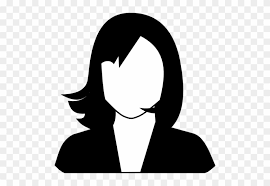

In [125]:
token = jwt_gov_decoded_presentation['vp']['verifiableCredential'][0]

jwk = resolved_did.did.authentication[0].public_key_jwk
pubKey = jwt.algorithms.ECAlgorithm.from_jwk(json.dumps(jwk.to_dict()))
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

In [124]:
token = token + 'x'
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

InvalidSignatureError: Signature verification failed

## University of T&I Issue Education Credential to Citizen

In [126]:
# citizen_prism_did = create_prism_did(citizen_client_controller)
# print(citizen_prism_did)
citizen_univ_schema = {
    "firstname": 'Wilmien',
    "lastname": 'Du Preez',
    "course": 'Web3 Developer',
    "grade": "First Class Honours",
    "completion_date": "01/12/2022",
    "issuedate": "21/12/2022",
    "expiry_date": "23/12/2022"
  }

univ_cred = create_credential(citizen_univ_schema, "schema:12345:univ", uni_conn.their_did)
uni_cred_offer = send_credential_offer(university_client_controller, univ_cred)
time.sleep(2)

In [131]:
citizen_uni_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
citizen_uni_record_id = citizen_uni_creds.items[1].record_id
print(citizen_uni_creds.items[1].protocol_state)

RequestSent


In [128]:
print(citizen_uni_record_id)

87de03ef-49bf-4e0a-b482-fdd5aca3c7d8


In [129]:
citizen_uni_cred = await accept_credential(citizen_client_controller, citizen_uni_record_id)
print(citizen_uni_cred)
time.sleep(2)

IssueCredentialRecord(subject_id='did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0', claims=CreateIssueCredentialRecordRequestClaims(additional_properties={'firstname': 'Wilmien', 'lastname': 'Du Preez', 'grade': 'First Class Honours', 'issuedate': '21/12/2022', 'expiry_date': '23/12/2022', 'course': 'Web3 Developer', 'completion_date': '01/12/2022'}), record_id='87de03ef-49bf-4e0a-b482-fdd5aca3c7d8', created_at=datetime.datetime(2022, 12, 21, 10, 49, 42, tzinfo=tzutc()), role=<IssueCredentialRecordAllOfRole.HOLDER: 'Holder'>, protocol_state=<IssueCredentialRecordAllOfProtocolState.REQUESTPENDING: 'RequestPending'>, schema_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, validity_period=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, automatic_i

In [132]:
time.sleep(3)
uni_cred_record = issue_credential_record(university_client_controller, uni_cred_offer.record_id)

uni_credentials, citizen__uni_credential = check_credential_state(university_client_controller, uni_cred_offer.record_id, citizen_client_controller, citizen_uni_record_id)


Current state for Issuer Credential Record 315ddd02-51ca-42b9-9815-02d08d694190 is CredentialPending and Holder Credential Record 87de03ef-49bf-4e0a-b482-fdd5aca3c7d8 is RequestSent
Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialPending Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: RequestSent 

Issuer State: CredentialGenerated Holder State: CredentialReceived 

Credential Record 315ddd02-51ca-42b9-9815-02d08d694190 Issued to Holder! Continue with notebook


# Employer Flow

## Make a Connection between Employer and Citizen

In [133]:
emp_conn, citizen_emp_conn = await auto_connection(employer_client_controller, citizen_client_controller, "Connection with Decentralized")

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponsePending Invitee State: ConnectionResponseReceived 

Connection established between Inviter and Invitee!


## Citizen Present Education Proof to Employe

In [134]:
emp_proof_request = initiate_proof_request(employer_client_controller, emp_conn.connection_id)
print(emp_proof_request.presentation_id)

RequestPresentationOutput(presentation_id='c6598178-fa0e-4c66-acc2-74d8d4ab5a1f', additional_properties={})
c6598178-fa0e-4c66-acc2-74d8d4ab5a1f


In [136]:
government_proofs,citizen_proofs,university_proofs, employer_proofs, dapp_store_proofs = get_all_presentation_requests()
print('Employer proofs', employer_proofs)
print('\nCitizen proofs', citizen_proofs[1])

Employer proofs [PresentationStatus(presentation_id='c6598178-fa0e-4c66-acc2-74d8d4ab5a1f', status='RequestSent', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})]

Citizen proofs PresentationStatus(presentation_id='13bdcf06-0432-45c1-9b37-6c9ca5b317d4', status='RequestReceived', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})


In [137]:
print(citizen_proofs[1].presentation_id)
print(employer_proofs[0].presentation_id)

13bdcf06-0432-45c1-9b37-6c9ca5b317d4
c6598178-fa0e-4c66-acc2-74d8d4ab5a1f


In [138]:
citizen_emp_proof_request = accept_proof(citizen_client_controller, citizen_uni_record_id, citizen_proofs[1].presentation_id)

None


In [139]:
check_presentation_record_status(university_client_controller, employer_proofs[0].presentation_id, citizen_client_controller, citizen_proofs[1].presentation_id)


Proof Presentation completed between Verifier and Holder!


## JWT Verify

### Decode JWT in Credential

In [140]:
citizen_proofs = get_client_presentation_requests(citizen_client_controller)

In [142]:
# print(citizen_proofs)

In [143]:
# print(citizen_proofs[1].data[0])

In [147]:
token = citizen_proofs[1].data[0]

try:
    jwt_edu_decoded_presentation = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_edu_decoded_presentation, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)

{
  "iss": "did:prism:8e72fcbd-fe1c-40be-98d5-422e53e707e9",
  "vp": {
    "@context": [
      "https://www.w3.org/2018/presentations/v1"
    ],
    "type": [
      "VerifiablePresentation"
    ],
    "verifiableCredential": [
      "eyJhbGciOiJFUzI1NksifQ.eyJpc3MiOiJkaWQ6cHJpc206NjM3ZDFjNmQyNDRjNjNjODBmZTA0MDUzNDJkZmFjMDU2MDhlZGYzOGVlNDRhM2IzMTVjYWQ3Y2M1MzI4NDllODpDcjhCQ3J3QkVsd0tCMmx6YzNWcGJtY1FCRUpQQ2dselpXTndNalUyYXpFU0lQeXhYcEF4M0VLTTZzQnM5eS1fYnBXZVBpUmZPOGtKb3E1czRMRnlXT1RER2lEdWp6b2luQU90TEFLRzhoVFpfRHpudkI1VjJmVDFjREw1UE1feGNfUWJhaEpjQ2dkdFlYTjBaWEl3RUFGQ1R3b0pjMlZqY0RJMU5tc3hFaURINkw4WDRGQUpNNUNjUzFPdmdJTGcxNklpdDZVa0I5RUZacGU1eEEwNHBCb2dBRnVzbTRJZ1BMSi1BM3BIQS03WXp5dl9wanhaQkVOTDVzWWszZ1gtbm53Iiwic3ViIjoiZGlkOnBlZXI6Mi5FejZMU2g0ZlpTUXF6UlF4TndXZHhEN041UXUyYk1yZkJyMmMxWENvSlFTd3hyc2Z5LlZ6Nk1rcXJ6YjFOcDJqTVR1bzJ1eUNUVnpIc3NXblg2bWJLMkRWYlU5aDR0RGQ3Y3AuU2V5SjBJam9pWkcwaUxDSnpJam9pYUhSMGNEb3ZMMmh2YzNRdVpHOWphMlZ5TG1sdWRHVnlibUZzT2pnd09UQXZaR2xrWTI5dGJTSXNJbklpT2x0ZExDSmhJanBiSW1

In [148]:
token = jwt_edu_decoded_presentation['vp']['verifiableCredential'][0]

try:
    jwt_edu_decoded_vc = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_edu_decoded_vc, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)

{
  "iss": "did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESIPyxXpAx3EKM6sBs9y-_bpWePiRfO8kJoq5s4LFyWOTDGiDujzoinAOtLAKG8hTZ_DznvB5V2fT1cDL5PM_xc_QbahJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDH6L8X4FAJM5CcS1OvgILg16Iit6UkB9EFZpe5xA04pBogAFusm4IgPLJ-A3pHA-7Yzyv_pjxZBENL5sYk3gX-nnw",
  "sub": "did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
  "nbf": 1671619804,
  "exp": 1671623404,
  "vc": {
    "credentialSubject": {
      "firstname": "Wilmien",
      "grade": "First Class Honours",
      "expiry_date": "23/12/2022",
      "course": "Web3 Developer",
      "completion_date": "01/12/2022",
      "id": "did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3Q

In [149]:
jwt_nbf = jwt_decoded_id_token['nbf']
jwt_exp = jwt_decoded_id_token['exp']
print('NBF epoch: {} EXP epoch: {}'.format(jwt_nbf,jwt_exp))

human_jwt_nbf = datetime.datetime.fromtimestamp(jwt_nbf)
human_jwt_exp = datetime.datetime.fromtimestamp(jwt_exp)
print('NBF: {} EXP: {}'.format(human_jwt_nbf,human_jwt_exp))

NBF epoch: 1671618150 EXP epoch: 1671621750
NBF: 2022-12-21 10:22:30 EXP: 2022-12-21 11:22:30


### Resolve DID

In [150]:
resolved_did: Response[DIDResponse] = get_did.sync(client=government_client_controller, did_ref=jwt_edu_decoded_vc['iss'])
print(resolved_did.to_dict())

{'did': {'id': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'controller': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'verificationMethod': [], 'authentication': [{'id': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8#issuing', 'type': 'EcdsaSecp256k1VerificationKey2019', 'controller': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'publicKeyJwk': {'kty': 'EC', 'crv': 'secp256k1', 'x': '_LFekDHcQozqwGz3L79ulZ4-JF87yQmirmzgsXJY5MM', 'y': '7o86IpwDrSwChvIU2fw857weVdn09XAy-TzP8XP0G2o'}}], 'assertionMethod': [], 'keyAgreement': [], 'capabilityInvocation': [], 'service': []}, 'metadata': {'deactivated': False}}


In [152]:
token = jwt_edu_decoded_presentation['vp']['verifiableCredential'][0]

jwk = resolved_did.did.authentication[0].public_key_jwk
pubKey = jwt.algorithms.ECAlgorithm.from_jwk(json.dumps(jwk.to_dict()))
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

{'iss': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESIPyxXpAx3EKM6sBs9y-_bpWePiRfO8kJoq5s4LFyWOTDGiDujzoinAOtLAKG8hTZ_DznvB5V2fT1cDL5PM_xc_QbahJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDH6L8X4FAJM5CcS1OvgILg16Iit6UkB9EFZpe5xA04pBogAFusm4IgPLJ-A3pHA-7Yzyv_pjxZBENL5sYk3gX-nnw',
 'sub': 'did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0',
 'nbf': 1671619804,
 'exp': 1671623404,
 'vc': {'credentialSubject': {'firstname': 'Wilmien',
   'grade': 'First Class Honours',
   'expiry_date': '23/12/2022',
   'course': 'Web3 Developer',
   'completion_date': '01/12/2022',
   'id': 'did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY

In [153]:
token = token + 'x'
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

InvalidSignatureError: Signature verification failed

## Employer Issue Employment Credential to Citizen

In [154]:
# citizen_prism_did = create_prism_did(citizen_client_controller)
# print(citizen_prism_did)
citizen_employment_schema = {
    "firstname": 'Wilmien',
    "lastname": 'Du Preez',
    "email": 'wilmien@decentralized.io',
    "role": "Web3 Developer",
    "photo": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQ4AAAC6CAMAAABoQ1NAAAAAjVBMVEX+/v4AAADt7e3////s7Oz9/f36+vr39/fv7+/y8vLp6ena2trl5eXV1dV4eHi3t7fKysrg4OCqqqpERERlZWXGxsaWlpaenp5UVFS/v7+AgIBsbGxOTk7Ozs6kpKSJiYkbGxs0NDQmJiYRERGxsbEiIiJoaGhTU1NeXl4vLy9JSUkYGBg8PDyNjY10dHQyCsxLAAAPMElEQVR4nO1da1/qPAzf1m1tuQoqIhxUvB31qN//4z29DNjWy9Jule08J28kPyGE/9o0SdM0QhEjhBNORDJUMFQyRDBYMumJQZlg0lwwuWQydBKWDlAyiSIpOrWKTsuiUyw+cxAtmINowUhhB6WHJDnxggNZRaMWSp9Z8j84/sFhgwMJoiknUmaoZEiZEa+ZaE6ZZHLB5JLJBIMlM0DJSYQpJyyJOjC4iXER1hfJUVKAF4l1qAAvEutQAZ4cS/KxyIFZPJYSI0bp6bEIJh2c5AhFSS8mbU8kR//g+AeHIxwVH1YVTSuiOZNWRFOz0jXJ3L4TQQh1K9lT50hqgzNOhWq5ymDJZCWGSoaqjBSW2SVTvg6yDyymY0YLLFb8TiS30flsfgfe3XxfvsRHery8ul9O8zN7NHLG/OykxShZvsVaelrfjFHxnf8PJ53S+ZUei8M42VxgSv4fcBA631vBEPR+l9LkfwAHnV42gyHofiQWm786hMP3QDA43Z3DlIoAhuBcEFEZ+RpXGBkbSYaqjPx8pgjDkw8HNOJ4f42BkrvSOfd2w1KtS1NmqqM0Tei1ExicZiPSLLlLnX/OScdzZzSYTd3l53fSQ8BBnz3QYPT8V8JBb/3QiOMVX2HOAYdtG6Kl7UA7XzTieMPwMEruWOeoYljLTMUWNzGaz1cY+uAPB8PDIrlbnX/E70jougUabIGhf1UIR1et0IjjG/oXOelk2hKNOJ4jreQhwkEoNE6x0EK1jgOFgy7boxG/89WiNyEc9jelSdoBGmK5dTSlPjpHRS2EwCsTrw+JBskU+/2SKR5LYn0sh8KKpGDa2tGCbmldcvc6d+CVVlwadZTmuBs04nhEOvNKTTqHd9LRV1dwfOPhxyyEdIVGHO/I4OGgNw6/d76x/vuD/gAcfn430DtOyDscjRlCC8OGQwFX3ipWAOgc4aCUX8DReGBPCKHbP+Z37POw2mIcNIRjwmdwOC6KYf1tGR7Ub5DCq38i98UCPmkRfgKjMStmLxsgxvdcUt8FrhdOuuWX1ekhL+DgX/Npehf3xQYMh9UyVmh3RIMPENO25RqfAQ7VabNk9C1wIApGY1NCg+Nh2p+aErCj6aEzg0OUNRS1EJIpyh8kU9RSSCY5MSxY4K9ZsMCZXDJZSVgSZfC58oIqcDA8DJHOFxaSA+lMonBrOHuxhcIxraLBAdHj8RiF9TsSR3PgMGlJ+qL9SSrdK2iwz+tdVLYcD9RJJ9DdBJHbUeDQ2+HZYOEAZ4zVqSK/51Hz3ic2LQYKB3A74UuLBpOgTTlfBIUjpCmFobFHBjj05nQT1JQ6lT84bX9lwP2EsQkNZj726tsfsW5jrSOdo7IX47LtCtgche3Zr4xoMFG6kpAdCaZzUCcdFM1+GqeKGB6aeqEVHWbMohnpKi0saDBZmnzJepBwJKAUum2qiOHxS/1MEhAO33moL8oqzUMytqBw2Ka0ThXxlZoSql0wnZNwKwu2WNJfh/9NGtBgSqufvkPhVpZwa7glLb4onvlNExoMD9Ugz+gQQzjNrC/ou4j8L5umChejBj6POJTOIZ108+CgxYLROFW4GI2cCRkcHPVM2Ot8MRpdbOQUkY/8DoAGE6RGPtcDhKOysGxHqAhk1vE7+8P/+RswVbggdR/vjgaDI5gpLScGN8dfjqKPaxShBXCqRNq4dkODmdKGo2KVs3IVJtMcQisJw+VotDQtEF/0EQt2lzA02ONT4HhDYXQmpOyGdXpEkZY308oZjcKwrGFThdtSZevqQRQiBzhWGc5Jx2ULuKn9dOZcjYBosDerlXZcg2HFLLS8df9dhwM/g9HQOWLjocFRLXO5Un48HI1IswX1HAwOJ8MLX4bIoqz+L4dfr8Khpgi/gugs+ncEosry2Bi4WuFQ61LXKJDWwap/KnmbR91GChgOdWvzkSbDCuGqj/QP7hYOHrUMykmvTXjSMRzjocFRLWkCOuRgOK6HBkc1BW7eSwHAockPPtPAcEizJEUXZkmKLsySFF1ijmYpEQ6xNEsnYdX91Ys2cGiyjCsaQmdR3Heywk7V/5HGpEcHYcmkqv68DRyaSt37ADoLJnIYS3APr37ACRq+auHQFEYxr39ITjqtzfeG7RQ7HJrdvPXA4Kg51vWQ1gkOTdnLflhw4FqCc9sGDk2V6UvJOnYKh5MPCw2HqgEcow9/ODTpH1kDFK5/B7SdYa4wxxPLgjl8RFkM3v1jOH1x6gR3rbNgumzBGB0fS6aUDFJ/OLR7vWPStc6CCeCVJlhz4AueC1Tg0NbqTklYr7RDOHSHWHb+cGjPS+0GAwfV1YT5u6VIW7r8k3AU89Ak2lJYwaeKtsUPbANSC4e2dPmiDoe/zmUmOnQgzPP81MFQYQ7tDPMTQyVDqwzF+tpabz9MV+DB4aDd6XwEIO+4BSNCpjZpr95w6IuIdn3v38HgJhfGOmPv5LEmccxpGsgrbQ2HzBFQTG43lUOONV/SN1tqKMcc9xEOKpuwkvHzrKlHh2960FCOueghHOn9+u3tEtbl6NYPDmQoxwwFRxtTmpAluOOTZ8bD1GFrFCqEc1pos8qilWUoW+pOlT+qQeibJxyGMzEL+EJb0TlrWGjbumGYzOvLycul5uD4g99GHPqtReNpFMgN08EhFAE7vJSOV6VthM+tvoLSK4gzOGHxS+iNhRaiCaWYXtxttm9Xm7ubreGcue74XzMchkruzx7DkU4nwlJlo/n9Xq8+J0CJsYLGSHccjtFVMDgKwxt5p1ISwsfDn+bmA867C/rDcJw2Bzi6Tv90kBzMoV0p3PBAluNSd3nnCU2ZHOwihAN37XWoCLOcw2d03V3Y2XkI59ClA44Hym3dHUZ93mexndWoETQrZjSigv5EvYZjYlG9RpbxUcoBMN98bcGYl971Fw6X4WG2p4gc6vgRuon3S/N5GFHFfM4QrqmdIbxvidn/QHQW739vt9urX03dtXZd6KwtaEgK8OS7JXjFuyV4xbulS1NiKqUj2KVD670hM8aWKKBNHpEOdNaWuxzggIwlm4fn0vj7zZQpRIZUYI0ucTc6KzOru30WNAb3j9uzkMOIBwW0QFmFO97TFRxs6VvuYXD8pg989mvRuGCGYbR8ta2ysh9S3+HgJmn6vHldX/5q6NvxC+Wvsjl+HQw8i7diSkd0sTPeyfAZ8qSkiw/btAwVZ3OThtGBuI34WFQBYdySp1SlkrbV6i7gOdqmonUPyhrsIc8TosVlPJug0xk5hJ9f4vvS9oMp8xPHabhOjJ1X/zCB2d4Oh9igRGj+J/59W7TcRNNvfhtLebygzPDxLe1aZ3Q6wBE5TK0mD08qEFlaSgpaHebD9W82VG7mt8+bp/h9SeuTx7DGHNqZ9NdJl6LT1d3y+aY5+XEI4/hzXIrugperMVJMq65EjtEbHUgLRuiNNKUOJnLUykFVJ83xajk4graN14iu5N2TEqMTLQyBFI3vQHDUthiMLqq2LeWWdtCCsaRzDY6mGyiNR3R1d1vaElinHwRNeehs0NOEFl0Xu9K5eqzYxfA2r+EUgAd0t1ZzfpbbHcfF4ryHvwzFP+XnCyxtQPVSXU5X4ny1izk4c6kcvra0suYE3bvWVQy+y82EAcGR0JF9qYUWeui6w4zdF4tzw5GQbGzJ68XXwLmiKey4zYLDEcAsMWFT864AcG9ScwLu4zZ197t70YIRZztTM2vgOqv3Oj5WO4plLUa/WjDaXJqE0nS3MhQGfYLgMAZw8dPV3ah4xl3q3L2TLkWzETeZf1tSfKCF1n7N4Of9BeVXxnelcyg42EMbPTf0igedqW32b9erixQzZ7SvcPCr7cc3zZeegfYlTdF9hR62yzEWIc/ZWzDWW6ESnN7O7BnfgiBlQFqXVEufXzzJ2Fn71m5Wljy7Bl+nAKkh1B9iMQkco361YKSLV7j2T4BON9rwzUwzkvUnhCOO9wI21xCihly8Qnspsw9OOiHgqxQkNfcn0DVlaCCRYusBHGRki1B01OymI4e5V8ajB3CMnO8TrXcRU9HwuWnwgSl0/hAOu44NgJsOr70r02XULuwUptT36pdMXv2CHep+jtRUnu5STFSiGYbprL2uRr6t+H7fdoZ+t9s3uOkIOdytV6ZnDNE5nJNOHGrkStTgpsNd0ho9kfPGLBh+s1eZGtx0J5e0QpuzwkG9TB6vaLDD4X/3tbzy+jyHvxLvO7utcKCRNxq81bhdZ/vS2aoFY+45OOI4teEBvMhET7ftaj9aVf/4WY64wU03XhkIoT1vznieEM5vWeFka1BgrvoBEe83dx4n3f+Wapub7ueSHumdkvPAoXa0AdPeBofDFbY6eqZngYO61BnXyeymowh8UllPlwA4VLf7AEfRrke8zsTrpIBDMkJ0hCVTiJYfaSoBs5Hlti/bLTcguiZGnW39ioqvL1lhp+p/nyD8SGY33XSsGk6vbicWujn85VSTr5DposDIVCDnQhNq0Dmgk67vUASltQmONi7pgb7wj8OBcvil3Rp6MNbHuWWhtfQ0Ij8OB/RyVQOZ3HRD9aQble9v+aEQDlIjaCFDW7WWLmlBnyTxC+GOLRiNm1SGHSvtXbEOZHDT2xnoI+0ywy5bmdHt0pXdMMCtmXIypQnR9NFzopkBjjbOzIm2CKk6QzahPb1SSP2olfTZdN01X16U1uEI66TTlnPFUPTS1kAfafWjcLSeK4abRlsEyVV6ilB3cFRshwoH7QIOrZsOu7MVQtfIz3YIu0oKw0oEk6sMlsyxZA+3XgF0bnqLhFKNrnCm6AwpYPH2O9rOcl3RC4IdAGmmL0p+uH+HuRENjB41RS+WWzmdaI7Jj++zdO+mOxe56Olh8vMhHBNNJ/oWZ0DaIYU6cUnf8Jl24Uj96gAnEncOY9GjiG+kp+lo5FHkotASoTPtwjFvbNwyz9sxva9wk84NprTpqFhePiqmHJyL0GjMaTESNG5gJuL1hL+cTieCFlNBBSPfJj+ycJecY9qsc+3gHC0B4N+C8VQbJkQX40qKLsaVhLPMyCdRHN2T/8jLDFaFOUmG6qxm0sN10feZtD2RHPIu639w/AVwFIY3irpuZ5gOUHJUJMokUQcGNzEuwvoiOdQFrKljYUU/JIe7rbgv5qAXV139g+PvhkNX/nAQHVlFRw1K91jysZ1JYkU6KYtOypsySdmjT4oVTrx2KqzoiWTyH0OmNgTTsTIxAAAAAElFTkSuQmCC",
  }

employer_cred = create_credential(citizen_employment_schema, "schema:12345:employment", emp_conn.their_did)
employer_cred_offer = send_credential_offer(employer_client_controller, employer_cred)
time.sleep(2)

In [179]:
citizen_emp_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
citizen_emp_record_id = citizen_emp_creds.items[1].record_id
print(citizen_emp_creds.items[1].protocol_state)

CredentialReceived


In [160]:
# while (citizen_creds.items[0].protocol_state == 'RequestSent' or citizen_creds.items[0].protocol_state != 'OfferReceived'):
#     citizen_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
#     print(citizen_creds)

IssueCredentialRecord(subject_id='did:peer:2.Ez6LSqBuN7DBbLASCPYda1XPvtnSJZnMXZ3V2YHDMSYHHULTj.Vz6MkecebpgrYrygqiYMEG2yhdmZKADXDqduStuRi9tEyNxLC.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0', claims=CreateIssueCredentialRecordRequestClaims(additional_properties={'photo': '', 'firstname': 'Wilmien', 'lastname': 'Du Preez', 'email': 'wilmien@decentralized.io', 'role': 'Web3 Developer'}), record_id='57b6a9d7-f897-44e3-b48c-a2af54010858', created_at=datetime.datetime(2022, 12, 21, 10, 56, 3, tzinfo=tzutc()), role=<IssueCredentialRecordAllOfRole.HOLDER: 'Holder'>, protocol_state=<IssueCredentialRecordAllOfProtocolState.REQUESTPENDING: 'RequestPending'>, schema_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, validity_period=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, automatic_issuance=<prism_agent_open_api_specification_client.types.Unset object at 0
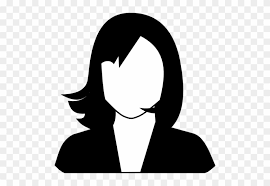

In [178]:
citizen_emp_cred = await accept_credential(citizen_client_controller, citizen_emp_record_id)
print(citizen_emp_cred)
time.sleep(2)

In [181]:
time.sleep(2)
emp_cred_record = issue_credential_record(employer_client_controller, employer_cred_offer.record_id)

emp_credentials, citizen_emp_credential = check_credential_state(employer_client_controller, employer_cred_offer.record_id, citizen_client_controller, citizen_emp_record_id)


Current state for Issuer Credential Record 2ed8125a-4c9a-48bb-9b07-c803e95cc310 is CredentialGenerated and Holder Credential Record 1722d115-99d1-4277-b8be-41106ca45826 is CredentialReceived
Credential Record 2ed8125a-4c9a-48bb-9b07-c803e95cc310 Issued to Holder! Continue with notebook


# Dapp Store Flow

## Make connection between Holder and Dapp Store

In [182]:
dapp_conn, citizen_dapp_conn = await auto_connection(dapp_store_client_controller, citizen_client_controller, "Connection with Dapp Store")

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: InvitationGenerated Invitee State: ConnectionRequestPending 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponsePending Invitee State: ConnectionRequestSent 

Inviter State: ConnectionResponseSent Invitee State: ConnectionResponseReceived 

Connection established between Inviter and Invitee!


## Citizen Present Employment Proof to Dapp Store Code

In [184]:
dapp_proof_request = initiate_proof_request(dapp_store_client_controller, dapp_conn.connection_id)
print(dapp_proof_request.presentation_id)

RequestPresentationOutput(presentation_id='ca774488-fb6d-40a6-b64c-ff10fb44e0c7', additional_properties={})
ca774488-fb6d-40a6-b64c-ff10fb44e0c7


In [187]:
government_proofs,citizen_proofs,university_proofs, employer_proofs, dapp_store_proofs = get_all_presentation_requests()
print('Dapp proofs', dapp_store_proofs)
print('\nCitizen proofs', citizen_proofs[2])

Dapp proofs [PresentationStatus(presentation_id='ca774488-fb6d-40a6-b64c-ff10fb44e0c7', status='RequestSent', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})]

Citizen proofs PresentationStatus(presentation_id='4e02353e-1622-482f-9f4c-4c9e71fe3ed2', status='RequestReceived', proofs=[], data=[], connection_id=<prism_agent_open_api_specification_client.types.Unset object at 0x7fe38384fe50>, additional_properties={})


In [188]:
print(citizen_proofs[1].presentation_id)
print(employer_proofs[0].presentation_id)

13bdcf06-0432-45c1-9b37-6c9ca5b317d4
c6598178-fa0e-4c66-acc2-74d8d4ab5a1f


In [189]:
citizen_emp_proof_request = accept_proof(citizen_client_controller, citizen_uni_record_id, citizen_proofs[1].presentation_id)

None


In [190]:
check_presentation_record_status(university_client_controller, employer_proofs[0].presentation_id, citizen_client_controller, citizen_proofs[1].presentation_id)


Verifier State: PresentationPending Holder State: 404 

Verifier State: PresentationPending Holder State: 404 

Verifier State: PresentationPending Holder State: 404 



KeyboardInterrupt: 

## JWT Verify

### Decode JWT in Credential

In [140]:
citizen_proofs = get_client_presentation_requests(citizen_client_controller)

In [142]:
# print(citizen_proofs)

In [143]:
# print(citizen_proofs[1].data[0])

In [147]:
token = citizen_proofs[1].data[0]

try:
    jwt_edu_decoded_presentation = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_edu_decoded_presentation, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)

{
  "iss": "did:prism:8e72fcbd-fe1c-40be-98d5-422e53e707e9",
  "vp": {
    "@context": [
      "https://www.w3.org/2018/presentations/v1"
    ],
    "type": [
      "VerifiablePresentation"
    ],
    "verifiableCredential": [
      "eyJhbGciOiJFUzI1NksifQ.eyJpc3MiOiJkaWQ6cHJpc206NjM3ZDFjNmQyNDRjNjNjODBmZTA0MDUzNDJkZmFjMDU2MDhlZGYzOGVlNDRhM2IzMTVjYWQ3Y2M1MzI4NDllODpDcjhCQ3J3QkVsd0tCMmx6YzNWcGJtY1FCRUpQQ2dselpXTndNalUyYXpFU0lQeXhYcEF4M0VLTTZzQnM5eS1fYnBXZVBpUmZPOGtKb3E1czRMRnlXT1RER2lEdWp6b2luQU90TEFLRzhoVFpfRHpudkI1VjJmVDFjREw1UE1feGNfUWJhaEpjQ2dkdFlYTjBaWEl3RUFGQ1R3b0pjMlZqY0RJMU5tc3hFaURINkw4WDRGQUpNNUNjUzFPdmdJTGcxNklpdDZVa0I5RUZacGU1eEEwNHBCb2dBRnVzbTRJZ1BMSi1BM3BIQS03WXp5dl9wanhaQkVOTDVzWWszZ1gtbm53Iiwic3ViIjoiZGlkOnBlZXI6Mi5FejZMU2g0ZlpTUXF6UlF4TndXZHhEN041UXUyYk1yZkJyMmMxWENvSlFTd3hyc2Z5LlZ6Nk1rcXJ6YjFOcDJqTVR1bzJ1eUNUVnpIc3NXblg2bWJLMkRWYlU5aDR0RGQ3Y3AuU2V5SjBJam9pWkcwaUxDSnpJam9pYUhSMGNEb3ZMMmh2YzNRdVpHOWphMlZ5TG1sdWRHVnlibUZzT2pnd09UQXZaR2xrWTI5dGJTSXNJbklpT2x0ZExDSmhJanBiSW1

In [148]:
token = jwt_edu_decoded_presentation['vp']['verifiableCredential'][0]

try:
    jwt_edu_decoded_vc = jwt.decode(token, options={"verify_signature": False})
    print(json.dumps(jwt_edu_decoded_vc, indent=2))
except (jwt.ExpiredSignatureError, jwt.InvalidAudienceError) as e:
    print("[ERROR]", e)

{
  "iss": "did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESIPyxXpAx3EKM6sBs9y-_bpWePiRfO8kJoq5s4LFyWOTDGiDujzoinAOtLAKG8hTZ_DznvB5V2fT1cDL5PM_xc_QbahJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDH6L8X4FAJM5CcS1OvgILg16Iit6UkB9EFZpe5xA04pBogAFusm4IgPLJ-A3pHA-7Yzyv_pjxZBENL5sYk3gX-nnw",
  "sub": "did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0",
  "nbf": 1671619804,
  "exp": 1671623404,
  "vc": {
    "credentialSubject": {
      "firstname": "Wilmien",
      "grade": "First Class Honours",
      "expiry_date": "23/12/2022",
      "course": "Web3 Developer",
      "completion_date": "01/12/2022",
      "id": "did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3Q

In [149]:
jwt_nbf = jwt_decoded_id_token['nbf']
jwt_exp = jwt_decoded_id_token['exp']
print('NBF epoch: {} EXP epoch: {}'.format(jwt_nbf,jwt_exp))

human_jwt_nbf = datetime.datetime.fromtimestamp(jwt_nbf)
human_jwt_exp = datetime.datetime.fromtimestamp(jwt_exp)
print('NBF: {} EXP: {}'.format(human_jwt_nbf,human_jwt_exp))

NBF epoch: 1671618150 EXP epoch: 1671621750
NBF: 2022-12-21 10:22:30 EXP: 2022-12-21 11:22:30


### Resolve DID

In [150]:
resolved_did: Response[DIDResponse] = get_did.sync(client=government_client_controller, did_ref=jwt_edu_decoded_vc['iss'])
print(resolved_did.to_dict())

{'did': {'id': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'controller': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'verificationMethod': [], 'authentication': [{'id': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8#issuing', 'type': 'EcdsaSecp256k1VerificationKey2019', 'controller': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8', 'publicKeyJwk': {'kty': 'EC', 'crv': 'secp256k1', 'x': '_LFekDHcQozqwGz3L79ulZ4-JF87yQmirmzgsXJY5MM', 'y': '7o86IpwDrSwChvIU2fw857weVdn09XAy-TzP8XP0G2o'}}], 'assertionMethod': [], 'keyAgreement': [], 'capabilityInvocation': [], 'service': []}, 'metadata': {'deactivated': False}}


In [152]:
token = jwt_edu_decoded_presentation['vp']['verifiableCredential'][0]

jwk = resolved_did.did.authentication[0].public_key_jwk
pubKey = jwt.algorithms.ECAlgorithm.from_jwk(json.dumps(jwk.to_dict()))
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

{'iss': 'did:prism:637d1c6d244c63c80fe0405342dfac05608edf38ee44a3b315cad7cc532849e8:Cr8BCrwBElwKB2lzc3VpbmcQBEJPCglzZWNwMjU2azESIPyxXpAx3EKM6sBs9y-_bpWePiRfO8kJoq5s4LFyWOTDGiDujzoinAOtLAKG8hTZ_DznvB5V2fT1cDL5PM_xc_QbahJcCgdtYXN0ZXIwEAFCTwoJc2VjcDI1NmsxEiDH6L8X4FAJM5CcS1OvgILg16Iit6UkB9EFZpe5xA04pBogAFusm4IgPLJ-A3pHA-7Yzyv_pjxZBENL5sYk3gX-nnw',
 'sub': 'did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY29tbSIsInIiOltdLCJhIjpbImRpZGNvbW0vdjIiXX0',
 'nbf': 1671619804,
 'exp': 1671623404,
 'vc': {'credentialSubject': {'firstname': 'Wilmien',
   'grade': 'First Class Honours',
   'expiry_date': '23/12/2022',
   'course': 'Web3 Developer',
   'completion_date': '01/12/2022',
   'id': 'did:peer:2.Ez6LSh4fZSQqzRQxNwWdxD7N5Qu2bMrfBr2c1XCoJQSwxrsfy.Vz6Mkqrzb1Np2jMTuo2uyCTVzHssWnX6mbK2DVbU9h4tDd7cp.SeyJ0IjoiZG0iLCJzIjoiaHR0cDovL2hvc3QuZG9ja2VyLmludGVybmFsOjgwOTAvZGlkY

In [153]:
token = token + 'x'
jwt.decode(token , key = pubKey, algorithms=["ES256K"])

InvalidSignatureError: Signature verification failed

## Dapp Store Issue Verified Dapp Credential to Citizen

In [ ]:
# citizen_prism_did = create_prism_did(citizen_client_controller)
# print(citizen_prism_did)
citizen_dapp_schema = {
    "dapp_name": 'Wilmien',
    "category": 'Du Preez',
    "website": '11/11/1999',
    "description": "Pretoria",
    "dapp_logo": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4QAAAKhCAYAAAAIWGAKAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAgAElEQVR4nOzdeZxcVZ3//9e5VV3pLDQhhBhCzISIGcSQhE6IEZkIjoKyhH3fBkEBUVH5oqMOw/hjHAYdxmFYVFBW2dcAogaURQYhJCGEiBhjJkYmxBBiaELT6a665/dHgitLOl11b1X16/l45A9D1/m87VRX3889554DkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJmyrkHUCSpExNvaNETIcRK22EYhuxp5NQXEPavYYnj+rOO54kSVmyIZQkNb+ps1qJlb0gHgRMB0YDQ/7kK9YBK4BHgFkUWmczZ9+uHJJKkpQpG0JJUvPa9Z4S6fp/gHAWxHFAsgmvSiEsA86n0HoVc/Zx1lCS1LRsCCVJzWnKrRMgfBeYtvmDhLmE8DHmHrSgarkkSaojNoSSpOYy6mjY7qj9SHuuhjisCiOuJWk5iSdm3l6FsSRJqiuFvANIklRVO351Jmn5eohbVmnEVmK6P6OPXQLh57z8dJWGlSQpf5vyLIUkSY1h4nfbiZXrIA556y/ulUGkPd9lxD4zqjyuJEm5csmoJKk5TLhkCK2jHiKm7TWssoSetbuy8KS1NawhSVJmXDIqSWp8o46GLad8BpLja1xpGEkhIZTud+moJKkZuGRUktT4tthpOKHwKYi1r5UMOJmh08bWvpAkSbVnQyhJanyDxu0HYXQmtWI6jNZtD82kliRJNWZDKElqfKHlkExmB/9Qr3gAo44uZldQkqTasCGUJDW2UUcPIin14fD5zREmMHTaiGxrSpJUfTaEkqTGNvDto4DhmdYMSRuVdWMzrSlJUg243EVS/zTpaihuUaSyrpXilm1UOteSDOiGWGbeIXmnU29sPWMYla5sb3DGSsIWO2fbhKpvdv5midLb2iFOB94JDAG6IPyGWJlD0vIoa37aydILcg4qSdmyIZTUv0y+dgSFwQdDPADiRAqDRxHLkJRSiCuAuUy9YxblV+5iwbFr8o6rTVB+ZTghh1OUQuIqm0YwddZQSD9KTE+DuMNff0GEkECsrGKr3b7H1N0vYO5BK7IPKkn58GB6Sf3DhEtbGTDy0xDPBDbl2a8VhOTrdC79Fs+c2VXreOqDafdOo/Lq49kWDRB79mf+EfdkW1e9MuX2DwDffv1G8A2tBM7i949ez9IL0holk6S64d1NSc2v/eZRDBj5Y4jns2nNIMAoYvoNBo37EbtcP7KW8dRHz9+2hlDM9sI9JCmvLHEGuV6NPT1h6p0nQ7y7l80gwEjgSobtfh7TfuB1kqSm5wedpOa2y41jCcUfQ9xts14f0xkkrQ8x6Yqx1Q2mqqm8ugLS1dkWjWsZMGJptjW1yYZ/8HBiegkwaDNHKBLTz1PpPIdxZ3qtJKmp+SEnqXnt9I0hJKWrIe7Yt4HieFqGXc2Ei4ZUJ5iqasX1naQ9czOtGeOzrH7AGcJ6NPnaHYjxmxBLfR8sfJ62yXv1fRxJql82hJKaV+voT0OcUZWxYmUGA7b7ZFXGUi3ckW25dBYrru/Otqbe0rAZCYWB50IcWp0BYyuFwV9n5295M0hS07IhlNSc3nXBcEJyZlXHDOEsJl/rUQP16NXf3AVhZSa1QrKW7hdvzqSWeme7o3cgFGZWd9C4E8W2g6s7piTVDxtCSc2pdbtDgWFVHTOmwygMPLyqY6o6XnpyFbH7O5nUiuXv8eJDyzKppd5pGbofMd3c5wbfSALJCVUeU5Lqhg2hpOYz7iwISY1Ol0/2Z9gMPzvrzYrrodL1DYjP1rjSStLuc1lxfY3LqNeGzUhIBryvJmMXBkxl3FlVWoYqSfXFixpJzaiNUOzjRjJvICQTAZ8nqkdP/cMa0u5TIKnRuZGhm1g+jSePWVWb8dVHRWJlfG2GDm0UBo+rzdiSlC8bQknNaBjE6i4XfU1M2xh7ug1hvXry6IcJhTOAcpVHTgnJOaycdVeVx1X1FIlpbX42YwW2nOwMoaSmZEMoqRklEGv3+VYYVKzZ2Oq7yrrvkLR8CqjWTGFKKH6ZdP3XWHF9WqUxVX0pBP99JKmXvKiR1IzKEKo9Q/SalLSrVmOrGp48OgW+xZRbl0JyOcQxfRhtBYQzmHvArdWKp5pJCclqoPpLO0MC6365turjSlIdcIZQUjNaA6E2h4aHpIP/vaijJmOruuYdOpsQdgX+G1jXuxeHbojfgfhe5h1sM9gYuonpM7UZOqyje/XS2owtSfmyIZTUjNaRdi+qychpzwKgsyZjq/rmHrSK5285A9J3A2cDC4A3OlC+G3gW+DeI7+b5Wz/GvEOXZxVVfbTmYSDeB6H6Y6fd81n6dWcIJTWlGnxqSlIdaL/lo4TkuzUY+RTmHXJZDcZVFkYdCaOOGEFankAojILYBnRAXEEoLGbFjc+x4qa8U2pzTbpiBC1bPUlMR1V13Fg+kflHXFXVMSWpTtgQSmpOO1/WRmn4LyBW78IwFNfw+0feya+/XpvlqJL6ZtgM2P6M84B/rN6g8Vl61r6HhSe7VFxSU3LJqKTm9PTHO0i7z6/qfa/Yc77NoFTH1jwMlVfOh7CsOgOGbmLlLJtBSc3MhlBS80pfvQzS2VUZKxQepvuFS6sylqTaWXD8WkI4DkLfn/mL5f9g7Zx7qpBKkupWIe8AklQzv5tVZrujfwJ8CHjb5g8UllB56VAWfux31YomqYa6Vixn6NRfEQofAQZsxggpsXwJa+f8I0sv8GxDSU3NGUJJzW3ugSsIxY9AeHSzXh+SuVRe+RAL/sEt56VGseansOzi20mKewOLe/nqtcBpdD33WZZe4Jmjkpqem8pI6h92vqyV0vD/B/GzwLC3fkFYA/FiQvF85h7gMRNSo5o6awix/AngY8AOb/KVqyHcSiyfx/zDPW5EUr9hQyipf5l87WgKg4+GeAAwERjyJ/91HbCQUJhF5ZXv8eQxK/IJKanqps4aRCxPhTgdwjuB4Ww4cmQ5JI8DjzHv4NU5p5SkzNkQSuqfpt6RENNBxJ4RhJZBxMo6QmE1Ielk7kE+MyRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiQ1jZB3AEmS1A9MuTWBUAKKf/K3KYRuXvxJmWUX55VMkvo1G0JJytrYT8LWe44EdoI4AcLbgbaN/7UD+C2EZyAuojBwFXP2SfMLK/XB1DtHEMt7QLI3xMnAGGAYkGz8ig7gOeAZiA8Qij9k9f3LWHax73lJyogNoSRlZcrtQyEeChwFTOWPTeAb6QDmArcQWm5k7sy1tY4o9dnwD8LffGIy8FmI+7GhAdxUncAjhHARqx+4l2UX2RhKUo3ZEEpSrU2dNYRY/gSEMyGO2MxRVhEKF9Lz+4t56sSOquaTqmXKHSMhfh3i4UCpDyOlEB6E8FkKgxYyZ+8qBZQk/aVC3gEkqalNuW0PSGexYVZwcB9GGgzx70kGHMF2xz5D9wvL6FwaqxNS6qPpDyaM2O8AQpgF8X30/foiANtDPI5YfpUBI+aydo6zhZJUA84QSlItjP1UwvC//wSx8nWgtcqjdxGScwmlr/HEvuUqjy31zjZ7wd988nPEnvPo26zgG0mBKygMOZ05e3fXYHxJ6tdsCCWp2nY8L2HwO78E4Rz+fEfFakoJxf8i7TqL+Uc4c6J8TL4uobjF54g95/PHjWJqIxSuovLqKTx5lE2hJFWRS0Ylqdr+5hNnQfhXavsZGyB9L0mphZ41D9L5a5ePKlvb7AVbTjmOEP6bbK4nJhPTgbRuex9r52RQTpL6B2cIJamaJl39YYpb3A2xVjODfyF0EysnMv+w67OpJ2008YqdKG31EDEdnmHVMnAA8w65N8OaktTUbAglqVomXj6SluE/g3RstoXDKtKu9/Dk0cuyrat+653nFGmb9H2Ie2VfPFlK5eVdWXD8muxrS1Lzqe16f0nqL7Y/I6G45ZezbwYB4giS0rlsk8O1ufqnLSfPzKcZBEjHkQw4g+3PyKe8JDUZG0JJqoah7x1HKB6bW/1QOJxtD5uQW331H9vsVQK+kGuG0PJRhuyY5VJVSWpaNoSSVA0hORHi0Nzqx7REccvTnSVUzb39pOnE2J5zitEUBs/MOYMkNQUbQknqq+3PKEHIb3bwNUnLTN52wLC8Y6iJbbMXhOIh2W2a9EYiJK1H5JtBkpqDDaEk9dUWO08kFEbnHYMYR1LcYlreMdTE2ia3Ah/MOwYAoTiN7c9oyzuGJDW6nO/wSVITKAzeA2Id3GCLCUnp74Af5p2kbk29IyGmJdJXWykMHkpM2XCk4/oOklIXsdzF/CPSvGPWrQEjRxIKY4iVvJMADKWtfTwwN+8gktTIbAglqa9CYVLeEf4gFHdim70SXphtU/Oa9lvaCGE6hL2J6TRgB5KBI4jpxiY+QlICWEMoLmPKbfMhPEQs/4SVt69gxY05hq8zhSFjIA7JO8YGEUJhJ2wIJalPbAglqa/S7rEUBuadYqMwhg2f7d15J8ndLtfvQGHg6cT0cGDUJrxi2MY/7RBPJhQ62PawnzDqyG+y4sb7WXGjTXZp2OgNs6p1Il2f/1JtSWpwNoSS1Bfbn5GQDKif55hi2kZ/fz586h2jiOlXgGOJaWsfRmoDDiRWZrLtYY8y6qgv0r3qURZ+rI46ooylPUM3zqbWiXpYqi1Jjc0PUknqm4SkWEc312KR/vrZPv3HCVNuP5aYPgWcDPSlGfxTCbA7sfIApeGXMPHy+rkBkLWQlPOOIEmqrv550SBJ1VMmXd+Vd4g/CEkn0P9msN71tSGUX74E4pVAjQ4sj0VieiotWz/A1DvH16ZGnQvFjrwj/Lmkfn72JKlB2RBKUl/874UQ01V5x/ijwgqgf83ivOdHQxk07jZi5VQyeRQithPTB5h05W61r1Vn1q9cTqijS4fCwGV5R5CkRldHn+qS1KCS0jN5R/iDdP0y+lNDuOP5bZTX3QZhr2wLx1EUt7ybSVdPzbZuzmJlOYT6mCUMScqry+rnZ0+SGpQNoST1Vbr+ibwj/EFIfsYLs/NOkY1d7y4y+J0XAh/IJ0AcRnGLm9j1rrH51M/BumdWEdPFeccAIMaVrF+5JO8YktTobAglqa86nnpk47N7OQudxJ5H806RmfK6U4Hj8w0Rx5H2XM6kK6q1gU1961zaTbr+/rxjABDLs/nfCz1eRZL6yIZQkvrq1197jsr6OmjE0rk8d3X/mDGZdMV4Cq1frY9jB8IHKQz+ZN4pMvHCbCi/fFP+m7mEMjG9Lt8MktQc6uAXqSQ1g3g5ue/uGb7LC7Ob//nB7Y5JKG55/sYzF+tAhKT0ZXb6j/5xSPrKWxdB5eFcM8TyIl5d+kiuGSSpSdgQSlI1VDrvgbAwvwDJEn5396351c/QyANnQNgn7xh/JqZDGTDqC2x3TN5Jau+F2WV61p4LeZ1JGMqkPefx7Jc8ckKSqsCGUJKqYeFJncTyV8hnh88U4tk8d1UdPMdYY9sdkxDTT0Es5R3lrxRaj2ar6WPyjpGJ529+BPhePsXjbF6ac2c+tSWp+dgQSlK1/P5/7gJuzL5wcicvzb09+7o52LJ9LEkp4yMmNlGMwyi97eC8Y2TihdnQveoLEJ7NuPIq0u7T3UxGkqrHhlCSquV/L0wJpU9BWJRZzZAspuu5T7Hk3/rHBXLrdh8mpkPyjvGGQuEwxn6imHeMTDx9yiqIx0BYlU3B0Eksn8iTRy3Lpp4k9Q82hJJUTXP3X0t53SHAstoXCyuhcBA//9SK2teqF8m+eSd4UyGZyJB394/NZQDmHTKf8svHQLKmtoVCJ6FwImseube2dSSp/7EhlKRqe+r4xZTX7QvhmdoVCcsIxb2ZO7OGNerMdseUSFom5x3jTcU4hMKgCXnHyNRTJ9wP8SMQltamQOwgFI5i9f03s+yi2pSQpH7MhlCSauGpE54hFPcE7qXqx1EkPyGW38+y/85xV9McJK2jIRmZd4w3FyEU67tprYV5B8+h/PL7CMnNVPf9/iiR9zL3gLtsBiWpNmwIJalW5s5cRTLwAOBjwHNVGHEVJGfSstVHmH/4clbfX4UhG8jImaOI5fr/vVUY+Pa8I+TiqRNWsuySoyA5DMJ8+tQYhmXE9DSSQXsy/9D+MwsuSTkIeQeQpH5hlxuGkww4GeLHgHG9fPUKCN8hFL/Jsv9e2e8awdfsct3hJK035R3jraX3MO+w/fNOkatd724lXb8XJCdB/ACwKRsBlYGHgatJu+7kyWM6ahtSkgQ2hJKUrcnXligMnA5hX2A6sBMwiD9fsdEFYTGkj0HyfUgfZt6hHsI9+eqTKQy5PO8Yby29l3mH1ffmN1mZ9oOE8ktthOJ0SNohvgMYyR/f76uBXwELgMcgrmbeoVVeYi1JejP9Y2tsSaoXC47rZsMsyMMAjP1kwvC/H0FMWzd8Qehi/fNrWHR6/zhGQs1tzkdSYC3ww41/JEl1xoZQkvK07OKUZRevzDtGQ0gGZHTeXV8lLnWUJDWM+n84X5IkgPLLzxEa4NdW2rU67wiSJG2qBvjNKkkS8OKDKyCp/2cpQ/KrvCNIkrSpbAglSY1iFen6ahzfUTshSal09a/zISVJDc2GUJLUGP7vuhTiw3nHeFMxrqb88qK8Y0iStKlsCCVJjaPyyt11fWJSLD/G2sfX5B1DkqRNZUMoSWoc63/3MMQ6XTYaUmL3LRtmMiVJagw2hJKkxvHyojXA9XnHeF2BZVS67sk7hiRJvWFDKElqHP93HXT/7nJCsjbvKH8l7bmchSfXXy5Jkt6EDaEkqbGs+Z8lxPRbecf4MyFZxqvLL807hiRJvVXIO4AkSb3y8tMwYMQTDB53GDAs7zgQyqRdJ/H0qU/lnUSSpN5yhlCS1HiWXdxBpeskCOvyjgLpd/jdPXflnUKSpM1Rx3t3S5L0JkYdnbDtwZ+GcAF53eAMySN0PL0/i//ZZwfVPNpvHEJoGQm0AZ0QVvPyotUs/ue8k0mqARtCqdmM//9gyLuGEMJYCOPY8AsdYC2EJcTyctav7OTnn84vo1Qtk69JKAw5F+I/knlTGJ4B3s+8g1dnW1eqsklXlihusTskR0DcHRgHFNnwM5Vu/LMKeAy4jZDcS8fTHTaIUnOwIZSaRfstbYSwH3AEhN1542erVgEPA9eRtMzmiZmdmWWUamHU0QmjDj+HWPkSGy5iay8kjxLjEcw7uE7PRJQ2wa53l0h7Dof4RWCnXrxyFXAZcAHzDnF2XGpwNoRSo9v1niLp+uOBL7Phrm4vhEWE5Css/ufb6VjoYdpqXO03J4TkeEguhNj21i/ok+spDPoUcz6ypsZ1pNqZesc4Yvw2xA9u/iBhCbHndF5ZPJtfnl29bJIyZUMoNbIpt40FrgT26MMoKSG5lXT9acw/0gtcNa5RR8PIA3YiKX2bmO5G9ZeQroLwZZLSFTyxnzdQ1JjaJsL4f51B7LkJGFmFEbuJ6Rd55dn/4pdn+3MhNSAbQqlRtd88lVC8A+LoKo24gKR0CE/sv7RK40n5mHxtkcLgYyF+AdixCiOuIyRXkXafx/wjVlRhPCk/U++YQYzfhzikiqOmxJ6zeeVX/25TKDUeG0KpEU25dSKEH1Gdu7t/Iiyie+WePP0JN8lQ45s6axCxez9ITmTDLHprL0d4FsINpN3X8OSRy6qeT8pa+w3jCAN+CnFUDUbvJqYnMP+wG2swtqQasiGUGs2k746gOPQhqjPz8ddC4R5Wff8Qll/eXZPxpaxNuiqhuMVQYjqDUHgfpDtBGAMM549N4lpgJbAYeBziw8T4LPMPK+cVW6qqCReVGLDd3RD3ql2RsJLyS+/lqROX1a6GpGqzIZQaTfst3yUkH61hhRQ4nV995Vt0LKxhGUlSZtpvPJZQuhpibY9niT3XMP/IE2paQ1JV5XOQr6TNM/l70wmF42tcJYHwZbY/Y0SN60iSstA2uUQy4Is1bwYBQsuR7Pyt8TWvI6lqbAilRvG350Jh4BcgZnDOWhxNcctaN56SpCzs8KXdiWlvzhnsixItW5+YUS1JVWBDKDWK1tHjgD6cF9VLoXACbZOzOeRbklQ7oXBItgXjTP723FK2NSVtLhtCqVGEwgeAam4T/lZ2YszJYzOsJ0mqtrbJJUJht0xrhsJYiluOybSmpM1mQyg1ilB8f6b1YppQ2mZGpjUlSdU19hNtxHRstkVDKy1Dd8i2pqTNZUMoNYK//dcioWVc5nVD4V2Z15QkVU9hi+FA1ss3E9LuWpx1KKkGbAilxlAkhKGZV42VKh98L0nKVqVILtd76aDsa0raHDaEUmMoEmP2v1xjxV/oktTQQppT3e586krqLRtCqTGUCWFd5lVDsSPzmpKk6gnJGiDr5iwlKa3IuKakzWRDKDWGboirM68ais9lXlOSVD1Lzl9LSDL+/RG7qXQtybampM1lQyg1gl/+U0pMF2ZeN+16KvOakqRq6iKW52RaMabP0b1qWaY1JW02G0KpUcTKQ0B2z4KEpEx57aOZ1ZMkVV/HAgjJ3RlXnc0vz+7KuKakzWRDKDWK7lUPQ8hu2U+Mj/Gby1ZmVk+SVBsvzL6HUFyVTbFQptxxdTa1JFVDMe8AkjbRzz+zmvabbiYUP5lJvcA36ViQ0+50qntvPxFG7F8C2iDuQEzHEZLRwNYb/u4PysBa4P+A5yBdDIUV9KztZOFHfX/9qYlXJLQMHQSVUZDsAIwGRgBb8Mfv6TqgE3geWAlhCbGynFDoZN7B5XyCq+795lsdDP/QhcBXa14rdt/P+hXZLlGV1Cch7wCSemHny8ZSGv40xCE1rROSBby6/O/4+RnZ72yq+jXp6oSWtrHEyh6Q/D3EdmAHen9zcQ2wCHgM4n2E4lzmHri22nHr3sgDYbvjh0E6FcLfA7sBOwHDejnSOuBZYC6EB4jlR3jhRyv47XernViN7F3nD2Xw+IeI6cTaFQkdpK++nyePWVC7GpKqzYZQajTtN3+JUKjhXd7QDekBzDv0h7WroYYy5dYREA4HjgLagdYqV1gJ3A/xWkLpJ8yd2dwzXVNuK0GyF6QnAHsAw6tcoQPiHAjXEVpuZ+5Mj4/RBlNunQ7JjyC2vfUX91oK6RdY9+x/8MuzazC8pFqxIZQaTfvNrYTCHcCHa1Th31l9/5f5zTddztef7XpvQto1AfgsxMOBQRlUTYGlwDdJBlzBE/s1z6zhyAPh7ScNJ+35OMRTgDEZVV4D8XpC4SIKQxbz+IcyKqu61DYRxn/lUGJ6HVCq6tgxvYL1/3cKP/9Mc9/QkZqQDaHUiHb+9khahs0iJNOqOm5IbqRlq+P42R7+Qu/Ppt45kZh+EeLBVPuicdOtgHAhcBnzDm7sxnDqncOJ6Scgns6GZwLz0EVIbqSy/qs8eaTnw/V37bccSSh8E+LQKoyWQnoV65493Z1FpcZkQyg1qp0vHUnpbTcBM6owWgpcRmHgmczZp7MK46kRTbp6KMW2syE9lWxmBDdBWAp8gf/73u2svL2xZq2n/6RIz5pjITkX4ui842zUQUi+Trr+v5h/pM8I91dtE2H8udOI5cuBvjxT2Anhi5R/fylPneSNRKlB2RBKjaz9pkGEwjkQPslmX8CH1RDP5KUnvseSf2+sC25Vx5iTE0bs92Fi5RJgbN5xXkcK4S4IZzDvoOV5h9kkU+8aTyx/E+Ie1OURT+EZ4DReuPdhln8n7zDKy3t+2Er5lc9AOAPiyF68shu4F/gC655Z7DODUmOzIZSawZRbJkNyDrAXm94YroFwPcTzmXfIczVMp3o28buDaNnqK8BnINb7UUQrCcWP8dzV99btbOHIgxNGH3c0Mb0IqMZyvBoK3RDPJSRfY+5B3XmnUY6m3D4U4kzgCDZsHDWCv76R0QksZkMjeAMv/3wRi/8525ySasKGUGoWU+9MSHt2ICQzIX4IwkTgT+/4loHlwHwIPyAU7uGX/7SKl5/OJ6/yt+v3R5Kuv2HjLFaDCF2QfhX4d+YdWl9L1Hb+VisD3nYeMf0kjXPObwrcQ2HgSczZZ3XeYZSzXb4HyaChUBkJyWheex/HympC4TkIqz3vUmo+NoRSM5rwLRgwogi0QmwjJJCuX0to6aa0dZmf7ZF3QuVt0lUTKLbdAXGHvKNsllC4ild+dRq/OKs+NrGY9sOhlF++lpDsl3eUzRKSRaTd+zP/iGV5R5EkZcuGUJL6m4nfaadlq1lAvWx0srnu5JVfnciz/5jvLqTTfjCctOsOYrp7rjn6LCym/NIRPC5PdsIAACAASURBVHWih4pLUj9iQyhJ/cnE70ymZau7afxmcKN4J6/+5hieOTOf3XGn/XAY6at3ENNq7PZbD5ZReXVvFhy7OO8gkqRs2BBKUn+xy/XjSAY8RNM0gxuF5CrS8knMPyzbjWbe+c+DaJt4B4S9Mq1bc2EJScvf8cT+K/NOIkmqvULeASRJGWi/cTiF1jsh7ph3lOqLkyEtQ/oI634RMyk5/SdFSsP+C+IRmdTL1jBieTpbvfc2XvjR+rzDSJJqy4ZQkprdtHuLxPhNiB/OO0rNhMJubDFhIc/f/Mua19r2EBi8w8eBf6IuzxishjCGlqFb0rLlD3lpXjZNtiQpFy4ZlaRm137TqYSWSyA2afPymvAcIbyPuTU+vL79xnZC6QGIbTWtk7tQJu06jiePvjHvJH3y7v+C1jGtxO5BJAOGEdON/26hg1heQ2jp5Pc/7WLpf+abU5JyYkMoqf8ZdyZs9b6hxMp4QjIB2B4YDrSy4Vy2NcBvgWcJybMs/c/nWPPT+jwI/a1MvmY8hcFPAE3evLwm3smKGw7h+dtq8++1y3WtJAN/CnFqTcavNyFZySuLp/CLL6zIO0qvTLu3SKVrwsZZ8fcDOwKjgNJffGU3sAJ4FuJPIcyGsMCz9iT1JzaEkvqPSVcPobjFgRuf+5rGhibwrWbN1gGLIcyC9EbmHdo4uy+O+XiRbfaeBeyTd5TshJRYPoL5h99ak+Hbb/48oXB+TcauW/EaXph9Issvq/+bIrve3Ua6/nhIToI4gdcOVt90ZWARxCsJLdcw94B8jzSRpAzYEEpqfrveNZy0fCbEk9nQBG6uMoR7Ccl5dC6dwzOfq+8L5F2uP5yk9TqIvb0obmwhWULPS7vy1D9U92J+l+vHkbQ+DrEv76EGFLohfoR5h/wk7yRvaPL3ShQHf5SYngOMrNKoqyGcS8/vv8PCk/I51kSSMtDkz5NI6td2vqzElNtPJe15GuI/0rdmEKAIcSYx/SkDx1zH1DvHVCNmTex8WRtJ6ex+1wwCxHQHCoNPZdvDqjfmtoclJK1n9b9mECCWgLN590V/udyyPrTftBPFwfcR029SvWYQYDjEC2kZ+lOm3DqtiuNKUl2xIZTUnNpvHEFp+CyIl1Ddi0Q2NFnhSGLlcabecSTDZtTfZ2lp+KEQdso7Rm5C4XSGThtRtfFGHjQOOLpq4zWcsDul4R/IO8VfmXLLTELLQ8R0Rg2rtEPyY9pvOZlxZ9WwjCTlw2MnJDWfqXdNhjgb2JXaLo0fAvFghr1vCG+b+QAra7SRSW+NOaXE4O2vhbBN3lFy1EbLsOd4/qbHqzLadkd+BcLfVWWsxpQQiqNpGXptXRxD8d4HE0YedBrE7wJbZFCxRAj7MHB0ia3e+1Ne+FF9/KxLUhXU311tSeqLqbPaieXvQxiXUcWEWPl/FAZ+m50vbc2o5pvbesZeUGjCA+h7K57Otof1/d9k/DnDoXBsFQI1thB2p23S5LxjMGwGdL94MrF8IX+9a2gtFYEvMfDt5zhTKKmZ2BBKah47f2sHSO+GOCrz2jH9BwZsewHvuS/fZ/bGnAKh9DHIfxInf2E8Iw/Yvc/DDN7xQIhDqxCoscW0SGn4iXnHYPtP7wXhAnq/g2g1JBC+xFbTP5pDbUmqCRtCSc1hyi1tlEbcQEyzbwY3SIjpqZQ7Ps3We+QUARg8fiyhkGOAehIhtBzXp81ltj2sSDLguOplanChuB/v+Hx+Z1pOvmY0oXA1xCG5ZdjQFH7DjWYkNQsbQkmNb9xZCYSv1MFh4QmEr7L9GfnlGDBiL/rNIfSbICl9kEHjNn927237jQXaq5an8Y2mbVI+jdDWexQpDrmQmFZ5k6jNEduAS9jx/DwbU0mqChtCSY1vyLt2g+TUvGNsEFuBS5h0ZfbPE445JSFp3dflon8ixpF9amBCywzAi/4/iEUo7J1L6b857cNEZuZS+3WFqQx+h0tHJTU8G0JJje0dn09o2fLrGxux+hDjVAqD/yHzpaODth9KCC5j+zMxIRT33KyXbnsYhORDNth/IWmZwZhTsj2TcMLFrSSlL9ffuZrhy+z4b8PyTiFJfWFDKKmxbdm+D9RbExQTkpYzGLFvtjNLxS12JBSqd/ZeswjFaWx7WO8bidbRgwjFvJch16GwI1tOHp5pydLwDxBjnf2cAzCCweOPzzuEJPWFDaGkxvWOzyeQnAGx/j7LYjqegWP2yrRmafhkYlp/34vcxZ3Y+v2Dev2yQWNHEop5bVJUv0IYAozPtmhyYl3+nAPEeCLv+Hy2M6aSVEX1+eEqSZtiyE47EYq75R3jDSSE5MRsl40mu2RYrHGEwjAqr4zp9etKw3cgpr1vJJtdTBNahu2UWb1RRw4jGZDtzZXeCMmODHqHGw9Jalg2hJIaV2HghyHW7wV7KM2gbVKG59elHkb/emJaYuDY0b1+XUjG+/zgG0i7/zazWtseMoNYruedc0u0bLlH3iEkaXPZEEpqTBuWi27eZiFZieU2ttpteia1xpwCMe39LFi/EIE4rtcvq6x/e/WzNInCoAyPfkjel12tzVV4H+/4fN4hJGmz2BBKakzJgCEQJ+Yd462FrDYlGURhoMcjvJF0/Xa9fk3LltlunNJIYjmbZyu33gNipQF+ztkRqN/VCpL0JmwIJTWmQdsPJ2lpgO3e03dnVGgQ4MYWbyj0/mI9lm0I30isZLWEs5Wk1PvlvlkLjKB1tDdkJDUkG0JJjancMQqon7MH30gojmTrPbL4rB0Cof6/H3kptm1OA+PvyDeSXUNYAur/xk8oligMrufnHCXpDfnLTlJjSnuG0QifYaE4hOxy1v/3Q80iq/daEWIj3OhIiN2NkFOS/ooXD5JUW4OA3h+K3nvpxj96PbHSnXeEphIKHRlW830tSTVkQyipQYUGuUgMHUAWzcg6iF0Z1GlM5ZfW9f5FmTY9DSbpzKhQN4T6f19HuiluuSbvGJK0OWwIJTWmpLQaKOcd4y2lXR1kM8PRCdT/hXNeQumlXr8mllfXIElzSIorM6rUDWRVa/PF7k46FmbVJEtSVdkQSmpMhYEriLEBlgGG5bz4YO3LLP92F5VX19a+UIMqtC7v9WvS9b+rQZLmECsrMqnz4oPdpOuXZVKrL0JxGaSbMQstSfmzIZTUmF751RpieVXeMd5a+nRmpUJhWWa1GklIoGfNsl6/rrjF4uqHaRKx8uvMaoXCE5nV2lxp9zP8+mv1v2JBkl6HDaGkRrWOmC7IO8RbCsVHMqsVy89kVquhhHVUup7r9cvW/WIpoeBF/l8JQMzwvRZ/kl2tzRFSYuXHeaeQpM1lQyipMf36a0B6X94x3lQorGDZxc9mWPHJDGs1jlheRddvN+M5tLCMWHGjkL8UwjrKL2f3vl52yUJCofdLfrOzlvXPP5h3CEnaXDaEkhpXz+9nQ6jf53bSnnt58cHsNppYv3IBIWmA5yqzFhbQuaz3G+68NK8DgrOufymmy3l1eTbPEAK8+GAXsXJzZvV6K5YfpPuF3s9AS1KdsCGU1Lhe/c0SYqVOl5OFMqRXZlszLiGmXpj+lfgQz9/S+51en7+lTOzJbslvo4iVR+l+MdsdbSudlxOSOrz5E1Iqr1yyYcWCJDUmG0JJjevXX4OeFy+q0zMJH+GVX83JtOK6xetIex7OtGbdC130rN3870lM79vQ3GuDkFLp/BHLv51t2d9+dwkxrb9Zwlh5mHW/eDDvGJLUFzaEkhpb59KfELsfzDvGnwtlqJzHL/8p20Zi+bchhLvrtEHOSbqEF360+c+7vTR3PiHU8/NrWVtDuj77WdMXH0xJu86DpI6e6QzdxPLZ/Ppr/rxJamg2hJIa26+/lhLTs+rqWcIQbmfFTffnUrt7zYM0wkHeWYnlO3n+ls1f3rj0gnWk5XuqmKjBpffz0vx83l/LL19C7Dk3l9qvK/0Wnb9+NO8UktRXNoSSGt9LT86H9D+BOrhTH1aSrj+T52/NJ8ui09YQe+7MpXa9CUk35Zev6/M43auuJiR18N7KW4DKq1dmvlz0NS8+CL+59GJCoQ4a9Dif7hfP4Zf/5PtCUsOzIZTU+JZ+HdavPB9iPrNyfxC6CeF05h+Z78Yu61ddTkh87i2WH+SF2X0/XP7FBxdAdHMZ0mdY88iDuUZ48cEyPWs+RkgW5ZhiFXAET5+yNscMklQ1NoSSmsOiT3aSDDgKwsJ8AoSUWD6bFTfnPzv38qIFxDg77xj5CmXS8gWbtbvoX3r+lpTyugv7/bOZac+FLP92/seaPPXRlYSWgyAsyaH6KsovHcS8Q/OoLUk1YUMoqXk8sf8aKq8eBGFBxpVTQvIfDBjxn6y4If+mYfm3IV1/AYT8L95zE+fw6v9Wb8fVV379Q0jnV228hpMsptxxY94p/uCJ/ZZQGPAhIMOZwrCMyisH8NRHfW5QUlOxIZTUXBYcs5RQ+AiEB7MpGLqJlS/SMvSL/GyP+lmmuX7lw8AP846Rj1CGeC7Pfql6Z+X96iudxMq5/fMIirBhh8+nT+nIO8mfmbPvMsodexIKt2dQ7VFC2JMFxz+WQS1JypQNoaTmM/eAlax7dm9C8jWghgdoh+eAg+hY8DV+tkf+M4N/6pnPluledTaE+rqIz0II97Dq+9V/nvSFH9wLoT822Y/y+0evzzvE63rqxNW8MPsICCdCWFWDCh3A2cTy3zP3oGU1GF+SchfyDiBJNTPuTBi2++7EeD7E3ao4cjchuZ7yK19kwbH1fcRD+83nEQr/mHeMDHVQWbcrC07o+2Yyr2fyNTtSGPw40FaT8etO0kXa+X6ePGZO3kne0tRZI4mVz0I8GRjWx9E6CcntlF/+CguO93lBSU3NhlBS85tya4kYZxKSM4FpbP7qiG4IN0P8Bmn3Ap48qr5mBV/Puy8cQuvonwET8o5SewHS9Wfy5FH/WdMyu9zwOZIBF0CsaZk68W/MO+TLeYfYZMNmwDvOGknafSxwGDCV3v28L4ZwI7HnOopti5nzkdrklKQ6YkMoqf9ovzEhtEwEjgL2AnYAhrzJK1I2LBmbD+FuQriZwqAVPL53BmGraPI10ygMuQ9is89q3UPl1UNYcGxtN9Npv7FEaLkJOLCmdXKXPkLP2r1Z+LHOvJNslim3JsAoCDOAKcD4Df+bQRu/ohtYCSwFngQepmftYhaeVP83eiSpimwIJfVP4z4HW+0+EtLxEMaxYYnZVmxoAl8EVgBLCckS5h7U2M/hjfk4DP/gqYTCRUAx7zi1EZYC72fewdmcATn56lEU235MTHfMpF72noO4p8crSFLzsyGUpP7gPbMTKq9cSEw/mXeU6gudxPKezD882+fcJn5nMqWtHyCmQzOtW3Ohi5Dsy9wDf5J3EklS7bnLqCT1B4/vlbLmkTOJ6Z15R6mu0AnhmMybQYCFJy8gFA5rrp1cQxekJ7LqXptBSeonCnkHkCRl5Pc/q9C2y/cpbTMZeGfecfoudEL6MVZcfwvrfpFPhNi9lLb2hRD3BwbkE6JaQhexcgqr77uO5ZflHUaSlBEbQknqT178cTdbz7iHwqB3EUIDP/8WuqDyUVbceAPP35ZfjHW/gNj9K7acMpeYHkjDNoWhG9KTWX3ftTaDktS/+AyhJPVH7ziryFbvu4hY+TgN9/hAWE3Scgy/vXI2K2/PO8wf7XJ9O8nAGzZsVNRQVhFajmPVXbNZ/p28s0iSMmZDKEn91XvuSyh3fBLCVyG+2fEb9SMkC0l7jmP+4QvzjvK6dv3+KNKubwP75R1l04T5pOtP4MmjFuWdRJKUjwa7KyxJqprHP5Tywg/+m1jeG5LFecd5CymheA1dz+9Zt80gwBP7riBpPQSSs4A6Pr8vlCFcSnntnjaDktS/OUMoSYIJl7YxYOS5ED8OtOYd58+FZcBnefnpu1h8TmMcGj79J9CzdgLEbwAfoK5uwIZFED/Lq7+5n2c+l3cYSVLObAglSRuMORlG7DuNmJ4H7EH+TUwHhMsIha8y94C1OWfZPCMPLjL6hEOJlS9DnJBzmhXANwiFS5l7YB3PXkqSsmRDKEn6c7veUyT2fIAYz4a4ew4JuiBcQ0gu4LmrFrOyCY5O3OW6ISQDD4V4JpB1Y7gSwoWEwhXMPWBVxrUlSXXOhlCS9PqmzoJ0/W6E4ikQZwJDa1gtBZZBuJLYcwWlbVbw2AdqWC4n036QUOn8AIQTIe5D7b6nncBjhORKul+8nYUnOyMoSXpdNoSSpLc25fYRxMo+hOQAYDowsgqjpsAS4H6IswiFB5l7UHcVxm0MU24bDuEDED8CzADGAMU+jLgCmAv8gJDMZu5BS6sRU5LU3GwIJUmb7u0nwoiZbVDZCcJuwC4Qd4IwFhj2Jq9MgRUQl0JYCMwDHoNkGfMO6qp57no35fZWYBTEyRueNQzvZEODOAIYAgza+JXdQAfE1RCeA5ZC/DmwAArLWXVXB7+9Mpf/C5KkxmRDKEnqm11ugKSUUOlqpdA6nA0NzGtSQstaOuatYYuJZSqdKQuOyytpY2m/BULy+hv7+H2UJFWJDaEk1auptw8ixuEQh0IyfOPh8a8dCbFu45/VwFpiZRXzDy/nllX9xzZ7wd+cNoy0ZyyhuAPEMRC3hTCcP9+ZtgtYAzwPYTmxewmhZTmrf7yW31yaT3ZJ0l+xIZSkevA3n4DhHxwLcQ+I74UwGRjLhtm2Vt74CIgyGzYQ6QAWA/OBnxGSB5l70Jqa51b/MOnqVopbzID0IxB2B8axYUOc3hxNUuYP79P4MIT7WP/8Iyz6pEuGJSlHNoSSlJeps4rEygSIRwEzgfFU7+y/bmAOcBvEO0kGLeeJfRrjUHfVh11uaCUUdycUT4J0H6Ct+kXCWkjvBK4llh9l/pE2h5KUMRtCScra1DvbiD2HQ+EkiNOo/QHwXRBmQ/wmhSH3M2dvl5bqjU2dNZSYHg/pacCOGVZeBOEiAjcz9+C1GdaVpH7NhlCSsjLhkkG0jjqVmJ7Bhh0ks5ZCmEsIX6U49B4e29MZQ/3Ru/+7lYFjPk6snAWMzjHJckLhfFb/+Dssu6j/HEMiSTmxIZSkWpt8XZHCoEMhPZ98GsHXkTwClc/SsvVcHtsz7zDK0673JKTdH4b4DTYsW64XzwCfpbzufp46wZsXklQjNoSSVEu73DiepPQNiB+m9ktDe6sLwqUkLefyxP4u0euP2m8dQUjOh3gsUMw7zusoQ7iKSucXWHCsmyRJUg3YEEpSLYz9FGy9x/EQvgHxzQ5srwcLCS3HMXfmwryDKENTbp8OXAdxXN5R3lp4hlg+gfmHz807iSQ1GxtCSaq2Xb8/hErnBYTkZOpvVvANhHXAp1j/u2tYdJrL85rZuy9OGDjmo8SeC4FBecfphXWEwums/vH3WHaR71FJqpJC3gEkqansfPkIkgE3EziMxrrpVgL2ozi4hfLLP6VziRfczWibjxTZesa/QfwqMCDvOL1UAvandXTKwO0eZe3jvkclqQoa6WJFkurbhItHMWDk3RDa847SBymEy2jZ6gwe29MdHpvJ9AdK9Pz+Qogfp2Fmrl9XGcLFFAadxZwPe4SKJPWRM4SSVA0TLh3NgLfdC2Fy3lH6KABTSde/ndZtf8Daxyp5B1IVjDurRGnrC4FTafybwQkwnbRrCK2j7mft4zHvQJLUyGwIJamvJl0xjNKwH0KYlHeUKppI63aDqLzyY175lRfcjWzEPvC2/f8Fks/Q+M3gH4XCe2gd/TKto37G2sfzTiNJDcuGUJL6YtoPWwnF64EZeUepskBIpjN02u9YcaM7OzayHc8/FvgPmu93fiAk72fgmF/w/M2/yDuMJDWq5rlTKElZm3xtQtL6dULyubyj1E7oJF2/L08e9WDeSbQZ2m+ZSijcB3Fo3lFqJ6wmVt7P/MOeyTuJJDWiRn6oXJLyFYoHEwqfzjtGbcVBJAMuZ9JVI/NOol6acvtQQnJ5czeDAHE4Ifku25/RmncSSWpENoSStDkmXzOSpOVCiMW8o9Re3IHikK8zYp+8g6g3YuVsoNE3OdpU0xk6/fN5h5CkRuSSUUnqre3PSNjqfdcRCkfmHSU7CVRe2Z8Fx96TdxJtgl2um04y8CGIpbyjZCd0UOn8OxYcuzDvJHVn6h0JMS0BRaBMT0eZhSd6ZIckwIZQ0mveeQ60TR4C6ZCNf5MQCmtZ/C+ddCzINVrdmXTVXhTb7u5fF9sAYREvL3ofi/+5I+8kehPvvqiV1m1/BKHZNjp6azG9i0rnITx1Qv9udiZdWaK45URI94BkV4jjgKHAIKALWAcsBxYCD0Ccy7xD1+YXWFKebAil/mzKrSMhfBj4EBuWlo0A/rTJ6QJWAfPZcNFwL/MOXZV90Doy+ZoShSEPQZyed5RchORM5h70n3nH0Jtov+VQQuGG/rGc+S+FMrFnX+YfMTvvJLmYOmsYsedUCCcA49gwI/hWUmAVhDuJPRcx/wg355H6GRtCqb+ZcnsCcRqEL0Dchz9vAN9KN4R7oPINQvFR5h6U1ipm3drlxqNJStdC7KfPYCfL6fn9FBZ+dHXeSfQ6JlzSSuuo/yGm7XlHyU94mDUP78n//lf/+XyaOmsQsecTkHy5j5sIlSFcT+WVs1lw3PKq5ZNU1/rpBY3UT7XfsgNwE/BTiAfSu2aQDV8fD4bkAWK8iamzdqh+yDq2/WeKJKXP9t9mECAdQ3GLo/NOoTdQGr4XMfaXjWTeQNiNITv2nxn8qbfvSKw8AOHrVdhRtgjxeAqD59F+y+GM/5d+/Fkn9R/+oEv9RfsthxMKj0M8lE1bRvRmihAPJVYeZ8ptR9K2SzUS1r8hO80A+vHMy0ahcBoj9utnz082iFA8rX/fsABIi5SGn5Z3ikzsetcHifGhDas+qun/Z+/O46uq7v3/v9Y+JyGEGBEhRUREpBQpIiTBUqsUhzoVFRCnWhWnOheHn239Wmqp9VprrXLVWqu9jiiiKCq11qlqHTGJgBSRomKKSBEDxhDCyTl7/f6IrVqZkuy9197nvJ+Ph//cm6zPuyHD/uw12Z4Y7y7KBk9l0M8LcOmxSGFJuQ4gIiHb/fdpdjrlpxgzDegW8OhdgXFsPzpN174vsObl/F2itcv50O2rv8KYoa6jxEBPyoe/wAcz33YdRD5nt2sGUrz9b8DqbzteX3rudzer5nziOkloqh8ei83Nou2wmDCkMKnRFG/fg22GPclHf83f3+8iBU5vfUTy2aBfQHGvqWB/QngrAtJgfsp23yymfMSlNL6enw8N5cP7YtIHgHWdJC5OoGLsE6zSLRSxUdJnIjanmds2PUhvcyhwq+sgoRh+RzX408GWhl7LpM+m7Gv/YtAvfsmSn4VeLhRf/980XXeqxPoHAyNpO0DNA5qBpcDfsP7j1B210mVMEVd0qIwUrt2u8SjtvzewN9jdwJTQdtraCuA1jPcMNeOT/cdhxIwz8YpuJJrl4T7GO4ea8b+PoFb0KmdOwqRucx0jNoy3ksY3dmPJz3RUfRxUjE2z06S/gSmcvXNbYv05rHnxiLw7XGa3q3vQbeDfsP6QCKu2YLPjqTvm8Qhrdl7prjDkmoOxuctpO0l7cxMha8HOxPqXU3f08ogSisSCGkIpPJUPlGG8U8BeBPTbzEdmwTyOzV1Bepu5zD04WQ8Vw+/ek1Tp02DLtvzBQTHN+M378/r3X4muZgR2OR+2++YsTHqC6yjxYfxPj/dP1gNivtr9DwMo7vlGJDNGiWFX0/zebrx5Uf6ciLvrxR7dR00DznVQfSmZ1d/gjTMaHNRuvz3u6E5R+TSs/33a91J0Ldaexfr3ZvLmRcn6uy/SQQW+8VwKTuUD1RjzKthpbL4ZhLaDU8ZivOfINV/LyDkRNladtPvNJaS6XhttMwhgS/FKr2fItcn5Wm2Nou3LwdPMyxdYD7z9XaeQT6W6jaLt0nH5j1QPUl2HuU4RqG2rhoE5xVH1gaS3meyodvsMvbE76W0ewvon0v5n3e4YcxclfX7CbtfoOVkKgr7RpXAMv/twjHkSaO8ym2KwP8RvfZTh08vDiBa4VLej3S0ds9V07Ztf1xKkywbjpStcx4gdk9qTirHaix4HXtG3tL/1v/keRdvu5TpFoEzxRU5ngb3icxn0ix7O6m+NqlnFdNnhNrBjOjFKGq94Kl37TQoolUisqSGUwlA5cy9SXe+iU6ex+WNIdZ1F5cx4v4Uf9Is0qZIfOz163qR/zM5nljirH7SSvsOxvhqfLxtMr4OS8ZIkn1WMTWPSOv12Y7ySPVxHCMxuV/fBeBPdhjA92GbIsW4zbEbproA9FxgXwGhpjLmeEfcMDmAskVhTQyj5b8hvyz89DCSAB1d7ACZ1adsfnZjqssMY8Nz+AbP+AHruf7DTDIHyC+SixXYyXg+yH29p6bWErcfoErADXMeIJX9D/jTKpf0Px+bi8KLtOAb9Ip7PjwN/2gdSPw5uttyUYtJXMOS38fzfKxIQfYNL/ivpez4wKLgBzQ8ZfFV8HzKKuh8Vj4upzTFsW+U6REDMQNcJYsnm0pTtpobQtVSXnphUWHfRJZvXtYJdzo9DE9U521YBqUNcx2hjhlHcq4/rFBtVtO2x4Ae7vN+kDqa4IsoTXUUiF4OHRpEQDb2pB5gzgh3UlmE4L9gxAzLoFyXAfq5jAGDSe9N1p/w4XMZmNfuyKf4GNcuutX7cE0y8l7K7YkwZ0NN1jE7r8pVSjDfcdYw2poxUafwO6ynd1QNzVBgj4+mEaclvagglv6XLRmO83oGPa9Lj2Pms+L11Tpf1wXjxeHNr/Z70npD8RmqX89OkSrVPblOs38t1hIJX0qc7+Pp7vnHFdGrveEzsdGoF1o/JYS7Ww0sHuOomINtWl4XXNHv7MOS34QwtEgP6AyL5zSv+NmF8n9tcBT2/E78lJMUV/cAUu47xqRKs3991iACUA/Fr/uMiXZb8h+2kFxGHAgAAIABJREFUK/5KCVbXpW1GXH4ndlz2494YE5/fQ6ZoR9cRvmTH4/tisyF9jUx/dK2L5DE1hJLfbDa8w1X8lvg1hP6GvkBMTsO0UFQej9nKzkmj35Wbo6+Na/56XYmS72y2lFj9rNn4Ndm2NcSVHLac2PxtFQlejH65iARsyG89vC7h/YFIlcZk+c7n2Fy8Zmusnw9vVMvQDOGm2ZyW04qEzeqOyS3zMiEOril4yWtqCCW/2Wx4v8RtLsw/Ph2lP1rBy3z6n2yMSTW5jlDwTLrZdQQJmVfUQqx+v3strhN8SePryzGpcMY23iogfv+bRQKihlDy16ILfay/KrTx/czK0MbuKJNucB3hC0zRatcRAhCzB7HYyboOIKbRdYIY84HkN8zpbVZibXxeTOWa/+k6wpe8P70BeCeUsf3WRSy6MD5ff5GAqSGU/GbStSENDJh54YzdCamu9cTmAd34tK5Z4TpFAJrQm+FNy36iZsS1xnkNGG1v2oQWYK3rEJ228pFVGBOT/x0mi0ktdJ3iS5rfzmKzz4Qwsg/+n0MYVyQ21BBKfvPXP0sYDZIxi3nr0uWBj9tZ6+vrwcblbXgz6W5LXYcIQAu5dVoWuSnG+9B1hIKX6rYWrF5abIzNNgPxWjnREU2LmrHZOtcx2thGNqxY7DrFRln/NjDB/s23/kpaP54T6JgiMaOGUPJb5qO5YBcEPq61t9H8dkxm4j7H37ACbDhLZtrLmGUs/VXyZwjfvQ5Mut51jNgyxfH4fitkJr0Sm4vJ7FHM+K3Lefe65C/1+7jWB/MX1zEAsH4Nb/4oflsmADKr54J5LNAxbfZaFp6d/JcKIpuhhlDy26ILs9jcVQS6B8xbTm79/wU3XoCW/MzHzz7uOgYANvsEH9cm/0EMALvIdYJYMimfpsXLXMcoeB890wwk/+VLGEw6fksbOyqzejYmBoe52Na7XEfYpIVnZ7GZS8AEtX+9hg0f3BDQWCKxpYZQ8l/L+w+ADWpfgQ/2Mpb8LL6HpeSapwe+ZKa9jAfZdfc6zRAo84brBLFk/QbSZZo9dS+DzeVP4xMkm3vddYTA1N+yHOs/4jaEWc66pQ+6zbAFi//fImzr6WA6+ULSrCDbdAKLLnTfhIuETA2h5L9FF/q0Np4MZkmnxzKpW3nz4ttpfjuAYCFZcMrCkDbWt8ezLLs+JvtdAtCyvA7jxW+JsHtLWP20liq6tmoOmPTfXMeIH5PFb37FdYrAfFxL24oX43CfuL2KJT+Lyz71jWt+G+qOmY3NndCJE3iXgjmI+SfFc6+kSMDUEEphWHDKcrCHgen4L3fj3Y6159H8dvyvILC5K3F3d14WuLJtz0ueSHVbhPXjOyvsis3OZdUcNcpxkPnoFTCayfgCuxo/k1/Lvd++ah7gaMuCncuGf8Vzu8TGLP7JTOA7YOa247OyYGaSXbcPteM16y4FQw2hFI7aI5dgvH2BB2nfnsIm8CaT+eh0ascnY0/cun88D3aGm+LmQVY/5XqGMlhNixvxW2tcx4gX42OzT7tOIZ/618NLMZ4O+Pk8m32JpsX5NYP9ca1PtnEqxot45so0kWs5j4Vnx3t28POa34baCXPBfhu844Dn2fSp483ADGxuf7JNxzH/xHgemiMSEuM6gEjkdrvGo+vO+2HMBcBooGwjH+UDq8A8gM1dTd1RydsntccdPUl3exHMoMhqGm8ZrWv2Yf4p8buSo7MqZ5yGKbrFdYzYMN5KGt/4Okt+ptP34qLy/msw3oWuY8SD8ck1ncS8E+92nSQUVbOGg3kabI8IqmWx2dOpO+b2CGqFq+qB7sBwMH2ANJAB8w6taxew4BTNsEvBUkMoha1yZl9MqhIYyGeNYQMwD1hA7ZHJvnS78v5qjPck0D38YqYZmz2EuqOfD7+WA8P+2I+i7eaDjeBrmQDWv4fldxzPKl3PFRsj7q3G6/IqWK3+waxi3T92Z/GPV7lOEpoR0w/F63ov2PIQq2Qx3mXUjP+fEGuIiGNqCEXy3fA7x5Lqdi8bnwkNiGnGpE5gyc8fpDF/DvX7gl3Ohx77PASMcx0lFqz/XeqOCva+L+mcirEeO538GlDpOopzfuZ2Xj/uZNcxQlU+AgZecgAmPR1sRQgVMmAvwuZ+R90x+bMnXES+RG8RRfLdvBPnYLMHgQlrGecqTPrIvG4Goe2C+szqm8HowQizhOV3POU6hfyXVXN84EbXMdwzWWz2etcpQtf4OtQd/RRe+ltgXgh49HfAfofaiTeoGRTJf2oIRQpB3TEv4a//Fpgngh3YvIDx9qHm8Mfzuhn8t6Y3nwJ08pxtvZlVc5JxwFKhWbd0NhT44TI29ywf185zHSMyrx2+FPgOcAGYFZ0crQm4Dsw3qJ2Yn8v/ReRL1BCKFIrXj68H/zCwJwCdfGA0K8CchVf0HWrGd/5+x6R497osfuaqwp4l9OrJrrvTdQrZhIa/NeBvuL5wd4SYLH7LFbx7XWH9jNZOaKH2yOvwinYHLgLae93GSuC3YEfwyRsXUDtB1+yIFJBC/YshUtgG/TzNNsOOBnsyMIqt21/YTNthO3dgUndTMy45x48HaY/bSkhv+zew1a6jOGG8i6gZ/1vXMWQzht5YTkmfV7H+YNdRomdn0/C3o3h3WmHfj1k+HL76syHAAWCrgMFAb9pO1gRYTduLwQVY/2m8kpeoOaywv2YiBUwNoUgh++plUL5HH/CrgZFgBgA9aTuVtBFYCywFMx+be4Uuvep5eUxhvXnfmMoZYzFFD/HZw1WBMIv4ZME3WfLzZJ++Wwgq7zsaU3QfWNdJImQayTbuw/xJC1wnERFJEjWEIiLttctkjx7fvg/sRNdRouNBrvkw5h2veyaSoOJQj51OfRQ41HWUCP2Chucv491prnOIiCSK9hCKiLTXu9N8sh9PBi9/7zj7ktzdrJiuZjApVj3mk1t3DpiVrqNEw6uh4fmr1AyKiLSfGkIRkY6Yf/IK/PXngSmAfTdmKdmmi1mlawcTZcWMZeBfkP/fo6aB1oZTeXdaYe5rFhHpJDWEIiIdlWt+ANv6e9cxwmWa8TOnM39Sgcw05ZFVj4EpmgnmBtdRwmOy+Bsm88kC7RsUEekg7SEUEemMkY+W4Lc+BPZg11FC4GOKzqDm8FtdB5FOqDi0mH5nPITN5tt+Qh/MVBqe+4WWioqIdJxmCEVEOuO1w1rIfHgC2Dy7CNv4WP831P/+/1wnkU5a9VgGzAngveQ6SqBs6600PPc/agZFRDpHDaGISGe9ccZqWteMB2+p6ygB8cHewNq5U1j1mK4ZyQc1hzeQW3ckeDWuowTCtt7KuqWTC/6+QRGRAGjJqIhIUEY+2p9cy0MYb7jrKJ3gY3PXsfz2H7PqMT1s55vh03uS7jYLmxvtOkoH+djcDax58WLenZZxHUZEJB9ohlBEJCivHbaM1o8OAe9Z11E6KIPxpvDP29QM5qt5x6/G63IEmBlA0mZ/M5jUJTT87QI1gyIiwVFDKCISpDfOXIlXfBjwfyTqgdusBXMSpvhXfPhnNYP5bO4ha1n/3kmY9BQgIf/WZhU2dyRe19+w7PoE/VyJiMSfloyKiISh/3ke24+ZBOYasN1dx9mCGrwuJ/Da2MWug0jEqh4cA/YWYKDrKJvgg3mK7CenMv+k5a7DiIjkIzWEIiJhGnHPYLyS68HuR+xWZZhm4DfgX03txCbXacSR4Xf1JNVtCvADsCWu43zOCjCX0frxnSw4WUtERURCooZQRCRse9xeTHrbY8G/EujjOk4b8xRwEfW3LODDP7sOI671OgR2PrMam7syBi8vmoFbMakrqBm3ymEOEZGCoIZQRCQqIx8tw289E+xkoK+DBFngFYx3Oe/9/ik+/Iv2YskX9ToIdj5rDNb/8aeNYXGE1RuAu7G5a6g7uj7CuiIiBU0NoYhI1Kpnd8e2fg9Sp4IdTvizMY1gHsOYm3nv98+rEZQtGjHdwxQPw6ROAjuR8F5g+EANcBc2N5O6ozUjKCISMTWEIiKuVD1Y3NYQ2uPAHA70J7jmsAV4HngI480m3X0lr+wb0NBSUEZML8PrMgq8w8AeCAyic9+nTWBfAvMXbO5xsEuoOyYhp52KiOQfNYQiInGw89nQ6zuDsP4Y4BtAJW2zMmXA5g76yNC252otsBCoA/MyxnuBmnE6KEaC1etA2PmsCqxfCQwFvgb0A3oD3fmsUfRp+55sAFYC9WD/Dt4C1r+3iEUX6JAYEZGYUEMoIhJXlTPKMUUVYHuA6UlbcwjQBGTANIJdi/Ea+GRhA29N0VJQERERaRc1hCIi0nGVM8Df4JEq60nbjGZvoBwobfsAm2m79J7VYJYDKzEmyz9vh3897Ch0TH3lCNhpkkdufSlel0Fg+oHtQ9uLgO0//SgfWAM0gF0BZhkmtRTrZ1j1KPzzNmfxRUQkmdQQiojI1ht+R5rUNn3A3xvMN2lb2jqEtuWCW6MZWATMA/9lLM/jpeupGV+YSwhHPprG39AfzH5g9wGzJ22XxLdnj14GWASmBpv7K8a8wPp/LmfRBZoxFhGRLVJDKCIim7fTqW37G03RBGA8MIzN72tsjyxtDeIcMPdT1H0Br+yX341M73HQ59iBeF2OxvpH0rYXL8jrHZqBOrD3AQ9SO3FFgGOLiEieUUMoIiIbN2hqmvI9xmJz5wB7E1wTuCkZ2hqZm0iXz+DVA/Nr1rD6YcDuh81dAOzHf5bVhqrtyhHbejVe1zpqDo+gpIiIJIkaQhER+aKqWSXAOOBS2mavXFgG5iqwd1N7ZLJPSx36O4+SPvth/UvBjnGUwgfzBDCVDx+bS/2t+T0LKyIiW00NoYiItOl3GvQ6ZMynjdieruO0MYvBXkLRdo8kcilp1YODwV4NHAykXccBkwF7DyY1hZpxy12nERER99QQiogIVM/ugfWvAnsiwe5nC0IWzByMN5macfWuw2yVqgeKwfsh2Cm0nboaNyuBS8DcTu0E11lERMQhNYQiIoWs32nQ88DRmPQdYPu7jrMFq8GcTlH3eM8WVs/uj/XvADvadZQtszPxupzDa4etdp1ERETcUEMoIlKovvGkR/bjH4J3BdgoDjgJQgaT+i3N70xl0YUtrsN8Qe8J0HfSgdjW24A+ruO0w0KMdwI14+e5DiIiItFTQygiUoh2vTjNdt+ahs2dSfvuvIsDH+wc0t2P49UDml2HAWDUM7Bh1Wl4xdeCLXMdp/1MA9ij+PAvz1D/B9dhREQkQmoIRUQKzeBfldFt4B1gkr15zHjPY9JHOl/uOOoZj+wnP8JmLycWB8d0lGnCbzmVj56dqaZQRKRwJO2tsIiIdMbgK8so3fWuxDeDANYfjc3OYuSjPZ1l2OFIj2xjHjSDALYMr8ttbD9mnOskIiISHTWEIiKFYtBUj26Drsd4+fPAb/3RWP9e+p4U/R7IHY6E3hMnYf2pJL4Z/I9SvJK7qHpwb9dBREQkGloyKiJSCPr9wKPXgZeD+X+uo4TkdlrXnM6C07KRVax68ADgUbAlkdWMjFlF5sN9eeOMRa6TiIhIuNQQikhhG3AhdP9md4zXk89meXwwDaS6NDD3u/G93qA9qmYdDeYusHG7YzAoPpiLWDH9Oj6YFX61yhkDMUV/BfqGX8wR481lw78O4o0z17qO0mFVs8rBVgOVYHaj7d+rB213bTYBDcAy4A0wc2l5fxF/Py/jLK+IiANqCEWksIyYDl7XfuAfCubbQDXQEyjhi8voW4C1wAIwzwGP0bpmMQtOTV6DOOLegXjFLwIVrqOEyzQB36F2wiuhlhl2SwlF2/0JzH6h1okDm/sdq586J1GHzOz64zTb7XUwNnsSMIa2n++tkQWWg5mNzd2GV7yAmiNCiykiEhdqCEWkMFQ/VIzlUPDPAfajY3uoFwA34xXdw2uHJ2PWpN8P0vQ68GkwCbgkPQAmtZjGBSNZ8rOm0GpUzfoJcGVo48eKyZJbdwTzTnjMdZItGjG9BK/kaOASYHAnR/PBPAFcTqrrK8w9JHkvgkREtpIaQhHJbwMu8thu7wPBXv7p0rEg1IO5mlTJrcw9NF6Xo/+3EfeeidflJrCuk0THeL+kZvyUUMYefucgUt1qgQTeNdhRZjHrl32LRRc2uE6ySdWzK7H+jWBHBTxyBrgHzCXUTlgZ8NgiIrGghlBE8lfVgxVgpwETCecUyJeAsyjefgEvjwlh+E4acl1fuvZ7FWwf11EiZbxGWlZ8i4XnLAx03J0mpan47n3gJf/KjnYzv+TDv0yh/mbXQb5o1NMerR+fCfYqwm3S64GTWPPKs7xzdYhlRESip2snRCQ/DZ8+CngVOJbwrgTYC3iR1o8n0WN0vH6f9jsDuvb7ccE1gwDWL6fLDlMZfFWw/yYVh42B1NhAx0yOs9m2aoDrEF8w8pE02U+uB3sj4c/Y9gP+zHajzmbPP8frZ11EpJP0S01E8k/1wweTKvkz2P4RVCvD5m6h/7k/ilVT2GOfQcCJrmM4dCiluwS1RBiG3lAM5pI8PqV1C2wPira92HWK/9jzT8VY/3ps7uwIq5YA0/A3/DDCmiIioYvPw4uISBCqHz4Qm70P6B5dUZvGpC+n/zk/oveEePxeTZWcB7bcdQx3bAmYi9nhqGCGK+41CiiMg3k2xRR/j2F/7O06Br0nePitU7G5HzionsbmrqbyvlMYEJ/+WESkM+Lx4CIiEoThdw3Htt4POGiEbBpTdDk7fn9S9LX/y1cvq8CkC3l2sI2XHsv2YwYGNNpksGEtPU4Iv5yi8rNcp2DH7x+N9f8/3D3DpDFF09juG3s7qi8iEig1hCKSH4be2INUtzvAOJwVs2mMmcbwu4e7ywCUDzsamyvg2cFPWb+ELhUnd3qcQT/vi9fl4AAS5QHve/Q7w90Jq5Uz+gLT3DfntgzMTez+hx5uc4iIdJ4aQhFJvkGXe3T5ymVgh7mOgvXLSHW9hT1uK3VSv98ZabAnOKkdRyY9gR2P79y/xTa7T8Dm3Px7xo7pz/bfdjMz1nu8hym6CmyFk/pfNpT0Npe4DiEi0llqCEUk+coG7Qmei/1Em1JNqvRMth8TfeXu1UPAc98Yx4W1A6k4tLLDn7/DUR6YgDYi5gObxis+kn5nRF96xxP2BjMx+sKb4XU5m+F3DnIdQ0SkM9QQikjymdSUtkNEYsQrnsz2+/aMvG562wNj97VwyqYxqUM6/Ok99u4HqMH+ov0o6RvtstGhN6QxXBy/U15tKaluF7lOISLSGWoIRSTZht9dCd6BrmN8ifX7UTbk+5HW7HeGB+wbac0kMOkx7HBUx/acpbfdEyeHFMWYSfUjVTok0prpbQaDOSDSmlvNTGDo79yfvioi0kFqCEUk2UzqDPcHTGyClz6d7cdEl61sUDnG6/jyyLzlDWG7b7R/39kOR4FXvC/YEDIlmPXTlPQZFWnNVOlRWD+uM989Kdr2UNchREQ6Sg2hiCTXrj8qxyuK7+mP1g6h3+nRNWjWDsSkol+mGn/dKe7Vkesn0nglWi66MV7RyMhqbT/GA29cZPXazYIpOoJdf6RnKhFJJP3yEpHkKhtSCV4f1zE2zYLXNbqGtevOg7F+PGdLnbJgitt/Fcj2+5aBHRBCoOTzM8MjO1imx969Melol6i2l/H2pKSPu+s4REQ6QQ2hiCSXV7xXbJeL/pvN7tM2wxGBXPPukdRJIi/9tXZ/Tq65NybVPYQ0yZcq7QNEcxXHNl+vxmbj/XNuUj0wRXp5ICKJpIZQRJJshOsAW+QVDyaqB+d0aYxnSx2z9G/35xivQie2boopByK6D9DryHLfaFlbTKpMDaGIJJIaQhFJpl1/lMYr6ec6xhZZv5wdjormlErr942kThLZ1vY3y6UDKrB+CGHygU3TdacekZQyqZ0iqdMpFlJd9UJGRBJJDaGIJFUJNpeEA1SKKeoeTU7rR/OAnkQmVcYO7bxf3s/o67kpNgfbDItmz5zNJuNKB9vay3UEEZGOUEMoIgkW8/2DbTxsLprftTar+/I2xetSCrTv+8W2av/g5vjNapg/z2p5sYgkkxpCEZH8od/pQbK22HWEWLM2ou83k4mmTieZ1EeuI4iIdIQeHkQkqfyEPCj6eF1aoillstHUSaT2bwY0qcYQcuQPk4rm588UrYikTmd5XVa5jiAi0hFqCEUkqTKYVPwfwIxpofndhmhqqYHZpFxzM9C+htmkmsIJkydSXddGUie37r1I6nSK57Nh5XLXKUREOkINoYgkVRZ/fb3rEFtmVvLh49E0aia1OpI6ydTEB/e37zNSJfF/4eCKScOHT0XzfZ0qXRBJnU7xm8EucZ1CRKQj1BCKSDK9/WuA11zH2CK/dSEfPRvNklGTTkCD7IhX1P7Zm8b5qzEp3TuxcRn8lmhmvpddvwivKN6z39Z/h/Xv6QWCiCSSGkIRSS5/wwvx30don4usVG5dMvZauWBzy9r9OUXbrQSaA8+SD2x2LRBVA7QWf0NNRLU6KPcUb/86or3CIiLBUkMoIsnVtHghNhffWTGTytK89LHoCtq/g4muXLK81e7PWFu7Gj8TzSxY0viZ5dTfHM3LmI+eBWvvjaRWh5gs1n/IdQoRkY5SQygiyfX2r5vBf8B1jE2yuRf48IllkdXLrF6MifuMqQPG88msbv8+tFxTMya9MIREyWdScyOtt+GDOZjUykhrbjW/jsZ50X49REQCpIZQRJLN5v4IJoZLtQzY3E189Gx0e9Ayq9/Bz2of03+zdi3Q/gM/Prjfx7bWBR8o6Qz4mVcjLbnyoZVg74m05lYxkFt/PW//Wi9iRCSx1BCKSLK9/r2lkJvhOsaXGDOP5nfmRFoz81ETxqiB+bKFfPRcx5Z+Zpue0/2O/8WYFlo/inZG7KNnIbduGpiYnaRr6/jkjfj9/hERaQc1hCKSfLkNVwAx2utlstjs5Sz+SbQHktTf7ONveFL7CP+Lv+FpPri/Y01d5l81GKNZ18+zuSV8suidyOu+/v16yF0eed1Na8H6F/D2r/XCQEQSTQ2hiCRf4/ylwJVAXK4IeATMI04qW/8pdDLm55gMfssTHf70j19fi599PsBA+eAx6m92tEzb/B541k3tL7mBtXNfcB1CRKSz1BCKSPK9czWsf+8GsB1/8A/Ocvz151A70c2sQcMLS7FZLRv9D38JH9fN6/Cnf3A/kIvxCZdRMxn8jLsTNWsnZsCcDGaZswwAmBdoemsq71wdl5dQIiIdpoZQRPLDogtb8LMngG3/4SGBMWsxqeN4/Xh3pyHW35wFe5ez+nFjc/ey7PrOzWZ9MOspoP0X2+clfwEfPdfxBjsItROWkW08BoyjnzO7lGzjMbz1/5rc1BcRCZYaQhHJH68fu5ps03gwDh7eTRM2ezLv/Nb9ErKWFQ/E7/ANB4zXTG793Z0e54P7m4FbOh8oH5hbIrt/cHPmT5pLtvEIiHp/p11KZs1hzJ+0Itq6IiLhUUMoIvll/qRFtK75DrA4uqKmCfxjWHbDbBpisN1s0QUN2MydrmM457c+yPxJ9YGMtb7+TjBrAxkrscxKGufF50TN+ZPmYtgXTPvvmOwQ8xK59fvzxukR/m4REQmfGkIRyT8LTl2Mn/k2mMcJ/aAZsxhj9qV24mOxaAb/rfm964nVyatRMy1k114b2HBrXlqGbb09sPGSyLZewz8ub3Qd4wtqJiyidc0+GO93QFj7djNgbyDV9TvMOyGYFwwiIjGihlBE8tPrx61iw7/Gg704pJmdLJg/4BXvQ834mhDG75zmd5bhZ/7PdQx3/Jl8+GRwe90+uB8yq6/FeAV6BYV5h5YPbnedYqMWnNrIO9eeA+YgMEHfj/gKcBBrXp7M3EN0eq+I5KWU6wAiIqFZ9acsXXd6mdKd78PmyjFmNyDdyVF94K/AJIq3/z2vHriu80FD8HEtVBw0n1TZMWC3dR0nWqaB3LqTWHpFsPsoU10/Zpuve2C+E+i48eeDvZgFp7zoOsgmrX8PPrjvXSoOuZNUaQ3YHYEd6diL7yyY57HZCyB3KXVHv82al23AiUVEYkO3F4tI4RhxzwC8kpPAHg0MpH3N4UrgCUz6Jt655pVYLQ/dnBH3TMLr8kcKaUWIzV5K3TH/E8rYOxxZwo7ffxXrDwtl/Hh6ig//8l3q/+D+MJmt1WMf2OX8gcDhwEHAUKAHULKRj26hbXn1IuAvYGaz5sWlvHNNZHFFRFxSQygihaf64WL8zBCMGQ3eSLADgZ589rDo0/aAWA/MA57DpOqoGZe8Q0X6/SBNr4MfBXuw6yjRMDX46/fh9ePDuzi96oG9wfsL2NLQasRHI7mmbzDvpOQepNJjHxhwYSnW7w1U0PazXgxksLkGTGol+CupPUpLQkWkIKkhFBHZ/Q8exT2Lwf57Fs3HtmapO9bN5fJBG/q7/nTZ4UXw+7iOEi7TiG3dl7pj6kItU/0Q2NzPwFxGXs+8Gh/beg51x/zedRIREQmPGkIRkUJQ9cBY8O4Hu7Elc3nAZLHZc/jgvj/wwazwy33jiWKyTbPAjg2/mCvmdrzi03ltbH68GBERkY3SoTIiIoWgqPsSuvZtxRTl54EoJvU7VtzzKz6YFfI1I596/64c3SufprjXYWB7RlIzUvZ51r83ifknaRmliEieU0MoIlIIPq6F4u1fpuxrXwG/2nWcYNk5NL99Ou9Oi/bQk9VPrWOHo58GMw4oj7R2qLyFeEWHM39SsKe0iohILOXx3gcREfmC+j/42NbJmNQfaDs4Jw94z/LJG8fz5sXhHSKzObUTFmMz3wWTJxeWm8XYDUfw2uErXScREZFoaA+hiEihqX6wGLxp2NyZrqN00hOkSo9n7iHuZ7IqZwzDdHkU/H6uo3ScNw/seGonLHOdREREoqOGUESkEO355zS5dVeAdyHY9tzHGA/Gm8Ha2tNZ+ssm11H+Y+ScgfiZ+8EOdx2lA54h1fUY5h7qvrkKKs8yAAAfGklEQVQWd0ZMB7+1mKJt+2Nzg8FUAB74LeAtx+YWYlKrqT0yT1YYiAioIRTJP4N+4VG2Wz+MVw12CJiv0HbnVgvwTzALMczjrctW8MkbjsOKU/1O86gY+z1s7nqgu+s4W8dkwP81pngqNYfH7/TLob/rQUmfm7C5iSRjW0YW493AhpWX8MZZbpbdinuVM9KYor2BE4CDgU1dUeMD88DMwt9wD68ftyyqiCISHjWEIvmi+uEy/MxEjHcysCefXbK+MU3AS8AfSZXMZu53oz2MQ+KlcuZwTOoOYJjrKFuwAlN0Fstvn8PKB+M7QzHqmTSta84FphLvw2ZWYtLnsOrR2dTfGt+vp4Sr6sHRYKcCo2nfS4xG4HawV1A7cVUo2UQkEmoIRZKuapYH5lCw1wCD2vnZPrAQk7oAm32G2okhBJREqJxZhklNAX7I5l8muOCDmY0xk6kZv9x1mK3SewL0OXYopuh68Me4jvNfsmBmYrwfUzMuGV9PCd6oJ0to/WQq2AuBziwbrwfvdJoWPsFbU4JKJyIRUkMokmQjppfhFV8D3ml0bnlaFriOVOllzD1E944VsqpZw4Grgf2IxZJHsxDjXcryO+M9K7gpvSd49D3x+1h/CtiBjtP4QA3Gu5RVf3qK+lsdxxFnht/VnXTZXVh/bEAjZrD+eaxbfCtvTUnez6lIgVNDKJJUIx8pw8/eD/bgwMY03oN4Rcczd6z2EhWyYbemSW97MMa7BNjLTQizFOw1WP9u6o6Kz8ExHVU5szum6ETwJwMDHCSoAe8qvKJHeG2slogXsj3nlJDLzAJ7aMAjZ8CeQdObt2umUCRZ1BCKJNFuV5dQ2v9+8IJ6u/sZ483A63IScw/VQ2Ohq5yZxqT3Bs759OGxNOSKWWAuJnUTmdUPsuC0/JutrnqwFPzDwTsD7N50bqneljSDeRybuwmv6FlqxsXvEB6JVp9jPPocey3W/2E4BUwT/oaDeP24l8IZX0TCoIZQJGm+drlH2ZArgJ+EVMEHpvCPqf9D44KQSkjiVM/ujc2NA8YD1UCPgEZuARaDeQjsA7x/1yJWzg5o6JirvG8gJjUOzBHAUII56XU1UAM8jEnNpmacLpiXz1Q9cDB4D4MtDrHKIpoWjeStKfn3QkckT6khFEmaPe4YRXqbp8GGOFtjmrCZfag7dl54NSSRdjoZKg6rAL8SzDeB4bQdZtQXKNvCZ2eAlcA7tB1d/yq29RVMur6g7zX7yhHQ96TewDDw9wQzgrZlpb2Bnmx8FrEFaABWAEvAzgfvJTCLWPVIA/+8LbL4khBDbyilZMfnsH516LVs9gLqjrku9DoiEgg1hCJJ8rXLoWzIX4Ex4Rczj/CPX4yncV7hPqjL1qm8rxiTLgFTDrYnbY3hv69byABNYFbjt6zG69JCqlsLc4Pb+pqXRkxP45UUA8XYbDkm/dmMjt/aglfUBGTINbcw7wT9jMqWDb9rLKluD4MN/7Ao6y+l+e0RLP5J8vf/ihQANYQiSTLsj3tStN3LkfxBx2TJrRvBvBMWhl9LRERCUz4cvjplFjAhmoLGx18/ntePfySaeiLSGTE4UlxEtlq6/IRomkEAm8YrOSGaWiIiEqIyTNGY6MpZD1Lfja6eiHSGGkKRpPja5cXAAZHW9Ir2o3x4mKcgiohI2L7600HY1qAOgto6Xrqar/0yzMNrRCQgaghFksIr6Yvx+kVa0/qD2GVyz0hriohIsHLrh0Re0/r98bps6aApEYkBNYQiSVGyY18w0b5tNaYUiLYJFRGRYKW7Rf9iz6RLKekb9t2lIhIANYQiSeFvqCD6n9k0/oYg7kYTERFnUo6W/ke1511EOkM/qCKJYYtx8TNrff2eEBFJMptxcP2D75NrykZfV0TaSw96IklhilYDUd835uMVN0dcU0REguRnV0Ze0/pr2bBK9xCKJIAaQpHEsCvARvu21doW0t1WRFpTRESC5a+fh4n6kc8sBdQQiiSAGkKRpFj/3nIwqyOtabxVLL1KDaGISJK9+7/LwSyJtqh9lrd+GvWqFhHpADWEIknx1pS12FxNpDWt/wKgJaMiIknWOC+Lzc2OrqBpwd/waHT1RKQz1BCKJEruvmjr2ftonBdtSRERCZ6//jaMF9ESztwLrF+mPx4iCaGGUCRJ1v3jQWB5JLWMt5h/XP5EJLVERCRcb/96CdbOCL+QyZJrvoK3puiEUZGEcHQvjYh0yFtTWqiceQUmdSOhvtAxPv6GK2iclwmvhogDlfeVYtJ9gB5A8af/1yZgLTa3grqj9T0v+alxgU927eUUbXco1u8TWh2bu5P19c+GNr6IBM64DiAi7TTkNyV03fnP4I0Jr4iZQ+ZfR/LGWXo4lmSrvL8EkxoN/iHgjQY7ECih7YXov1+qZD/9rwVYALyA8f5M65q5zD9FPwOSP8qHwVd/fjjYWYQyKWDnkWven3knNgQ/toiERQ2hSBINv3sgqdK/gu0b/OBmKbAvtROiWZoqErQ+34MdjuwP5nSwk4COzoYsAfNH8G+nduKq4AKKOFY9+3xs7moCbQrNEkzqEGqOeCe4MUUkCmoIRZJqxL2j8IofBXoGN6hZSe6T7zLvpLrgxhSJUNUD3cG7FOxpQPeARl2F8a7Ez/yBumN06q4kX+V9Hl6XMz9tCksDGHEeJn2kmkGRZFJDKJJklfdXY1L3gR3Q6bGMt5jc+uN4/Xs6GU6Sp/ohsP4BYG76dFloCEwd2FP5YNY8VtwTTgmRqHzzWWhdMxrr/xHo6M9MBrgdP/NjXj9ubXDhRCRKaghFkq7y/gpM6lqwR9Ox5T9ZMHdjMxdTd2y0F9+LBKHP9zx2OPJHwFQ+OygmJKYZ7Fl8MOtuVtyjS7cl+UY+WobfeibYc4D+W/lZLcCz4E2ldvwroWUTkUioIRTJB4N+4VG2234YcxGYA9i6xjADPIVJX82SKc/SuCDkkCIhGPV0Ma1rrwFzNtiIrlIyGWxuKsU9fsUr+6splPxQPbsMmx0D5jBgT6AfbafxQlsDuBJYAjwJdg4mvYSacfr+F8kDaghF8snwuz1Spf3BHg7222AGA31pO00xC6wAFgJ/w3iPkFtXz+vf1x90SaZdzk/TY+9rwJxL5PfqGp9c8yWseuzXWj4qeadqVprPTuMF8MFkyHzYwhtnOAwmImFQQygiIslUNet8MNdENzP430wW7HHUHvmAm/oiIiKdp4ZQRESSZ8Tde5Hq9jTWL3EbxKzCb/k2r39vsdscIiIiHePoraqIiEgHDb+zHK/rTe6bQQBbgdflRvb4v5APsxEREQmHGkIREUmOHY8Hr+RMYJjrKJ8xY0iVHus6hYiISEeoIRQRkeQoH16BSZ/nOsYXWQ9TfAk7Hh+DGUsREZH2UUMoIiLJUTrgWLB9Xcf4MjuY3uPHuU4hIiLSXmoIRUQkGXY83gNOdh1j0+zpn2YUERFJDP3hEhGRZNh+zGCMN9R1jE1L7cl23+zvOoWIiEh7qCEUEZFkSJUdgPXTW/5AZ8oo7rW36xAiIiLtoYZQRESSYh/XATbPgs19mx2Pdx1ERERkq6khFBGR+Nvx+DRel0GuY2yRVzIIiPMspoiIyBeoIRQRkSQow5gK1yG2yGb7AbqkXkREEkMNoYiIJEEp1i9zHWKLTKqUnvvrPkIREUkMLWsREXGt/7nQY3Q5JuWBgVRJI3MP9V3HipXu30iD8cC6TrJ5xkuT6qa/rf+t5/7Q/7x+2NxgoB/QE/CBDLAS6y/F2MXUHt3kNKeISAHSHy0RkSj1Pxd6HVhObsN+GG9/oBIYCJQCbQ1Pbn0LVbOWA3VgngMeJ9VtJXMPcpncrdY1ULJjEppkH+MlIWf4qh/2sLkhYE8CxmJz/YGNz562fc0aqZr1Esa7j+wns5l3YmOEaUVECpZxHUBEpCD0Pw967j8MmzsHmAj0aMdnZ8A8Bv71tKx8nr+fmw0pZXzteHwfek94Eyh3HWWzbHYF/3rka7w/vXBnuvZ83CPXNAq8S8EeTMe2p6wCcyPZpt8x/8TVQUcUEZHPaA+hiEjYKu+vYPt9b8TmXgV+QPuaQYBisOPA/IWSHR6mavbgEFLGXTPGi3+TZVJrgcJr2P+t6qFycs03gvkr2EPp+HNGBdippLu9RtWsiUFGFBGRL1JDKCISlv7nQdVDB2K818CezaaWy229NHAo5F6l6qGzGfyrQlr234jN1bsOsWV2KW374gpLzwNg5J8Gg30R7JkEd9Jqf+A+qmZNY7dflwY0poiIfI4aQhGRMPQ/z6PH6DPBPkrbIRpBKgf/esoG38TIOYVxxcH7032wC1zH2CJr57VlLTD9fjAKf8NfwQ4NYXQP+CHdvnofIx+L95JhEZEEUkMoIhK0/ud5bLfX+RjverBhNWweNncaNnszIx8rjKbQ5p5zHWHzjI+//mXXKSJX9dBQTPphsL1DrWP9sdjMdPqfVxjf7yIiEUm5DiAiknd2/cmRmPTvgKLwi9nh4G9DUfcn+bg25ncydFLx9h/SbdCZITbZnWQ+4KO//pSPa9e7ThKZoTdVUFQ2B2z/aAraQZTuvA0lOzzJ2lfz+/tdRCQimiEUEQnS8LsHgr0l0qbF2nPZfr+jI6vnyns3r8Tf8IzrGJtkM3Oo/0OD6xiRGXJNmi4VV2P9IdEWNuey7chx0dYUEclfaghFRIKyy+Q0qa7TgO7RFrZpvOJrGXJNRbR1Hcg13RzLe/6Ml2XDv25xHSNSxb32A3Osg8ppUl2vZvebejqoLSKSd9QQiogEpfs3DwVzoJPa1u9N6YBL6eWmfGSsfQZ4xXWMjXictXNrXIeITK8D06RKL3O4fHcAxRWnOKotIpJX1BCKiATh69OK8dIXgXV3FYTl+/Q8oL+z+lFYcFoL2abLwMTnagfjNZFpmML7010nic6O398bvL3chjCT2WVymdsMIiLJp4ZQRCQI6e5DwRvlNoTfg5J++X+J94ePPwPc7TrGf1j/f1n9dPyvxAhSqvQkcH6mSx/KK/N8SlxEJHxqCEVEgpDqemQsTr/0io5ih4nuc4Tp/ek+XtFFYBa7jgLmeUzqSlbcE799jWEZfGV3TCoGjZiFVMl41ylERJJODaGISCDswa4TAGBSQ9hurz6uY4TutcPW0rrmOIy3ylkGk1pGyz9PoGZck7MMLhT3GoIlHgcYmeJR7DK51HUMEZEkU0MoItJZu0zujtdloOsYAFi/jJKdIr4GwJHVT8/DpI4Dszb64mYFJjWev0+uj762Y+nuQ8F3t1f2C/w+lH29t+sUIiJJpoZQRKSzSnbqB7bcdYw2FvwNw1yniMSKe+D9Gc/gpQ8Dszq6wmYJXtFBvH/vvOhqxoht3c11hM+YYlJd839GXEQkRGoIRUQ6q3TXntgYbSFLde3lOkJkVtwDrx3+Armmb2G8sK+j8ME8TmvDt3ntsIWsuCfkcjFlWyO+Z3OzPHLr47F8VUQkodQQioh0lt8SrwuyTarw9lTNO3EJ/obvgPdLMC3BFzCrManJNL99BAtOWxn8+CIiIm6oIRQR6TSTdZ3gv8RoujJCdcc28cH9U8BWgZkBBNAYmkbwb8CYPVgx4wbevDg+9x9KG2MK8/tdRCQgMdkULiKSYC5PutyY3LpG1xGcWXEPrLhnEXAclTMH4hWdjPXHAYPY+r95LWAWgn8v1r+HuqM0I/h5pqjBdYTP8Ul107+PiEgnqCEUEemsNS+uYvt9fWwuJqsuvH+6ThALdUcvBS5l5KNT8TcMArMnMAIYALYnmH/f19gMrAKWALUYby4t79ez8FzNPG2M8d50HeEztoWmN1e4TiEikmRqCEVEOq8em20A434vofGgde0C1zFi5bXDMsDCT/9rs8ftHult2hr43DqfeSeq+dtaueYFpLfNgC3e8geHzPr1ZBs1Qygi0glqCEVEOuvdaS1s9806TNGBrqMAKzFmsesQsTd/kk+h7rXsrHVLF9O9eiXW9nMdBfzneXea9nWKiHRCTJY3iYgknOVPriMAYP1XWPlgnPZ4Sb75+LVGbO4J1zHAQG79w65TiIgknRpCEZEgtK5+BHB9mIsP9i4+fEIzXxKeD5+A1rV/xHiuv8+W0vj6M44ziIgknhpCEZEgrPtHPfCg2xDeItYvf9xtBikIH8yci59124zZ3LVaLioi0nlqCEVEgvDuNB+/9VowTe5C2CtZdH6zu/pSMD58wsffcBmYAO567Ai7kNaGu93UFhHJL2oIRUSCsvblBdjW37spbp6i4bmZbmpLQVr7yivgO/h+Ny1Y/yLeOMP1Em0RkbyghlBEJCjvTgNTNBVstNc+GG8V2cbzeHdaNtK6UtiW3eDTsvwyjPdKdEUN2NbfsObFGBxqIyKSH9QQiogEqXZCE5jjwUR0N5ppJtdyBivu0VUTEr2/n9+ISR8F5p1I6hlvJg0vXM670yIpJyJSCNQQiogE7aNnF2JbjwMT9vUPWUz6ApbfNpsPNWEijrx22HJs9rvghflSwsekZmDtySy7XgfJiIgEyLgOICKSt6ofrsTmZoHtH/zgpgHbehZ1x2jfoMTDyD/1xW+5DTgg4JEzWP/XpMsvZ+5BagZFRAKmhlBEJEwjpvfDK7kRGBvcoKYO/NN57/d1rH4quGFFOqv64RKsfz74lwDlAYy4COtfQN1RmgIXEQmJGkIRkbDtcVuadPcJkLsczKBOjLQSk76apkW/Y/Eljo77F9mCUc9C65r+YC8B+z2grJ0j+EA9mKsw6TupOVxXqYiIhEgNoYhIVHa/qYTiinHAycBebN2DcguwAOxteF1m8Npha0PNKBKkqgd6AxPBHAEMA3qy8fMLMsAK4HmMdz8t7z/FwnP10kNEJAJqCEVEotb/XOi5f1+sXw22CsxAoIK2B2UfaAD7DphaMDU0v72MNy/23YYW6YSe+0P/c7tjbd9P99T2+PT/4wMrsNllYFdQd6yaQBEREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREJinEdQETEqaoH02CLAQ/Igs1QO9F3HUtEQjDktx5d+3UHrxLsQKAnmCZsbgXG1GCz9dQdm3UdU0QkSmoIRaTwVM4sw6QOAL4LVAO9gVKgEVgOvITxZmGzc6k9Sg+HIkn3jSc9sp/sDfYC4ACgbCMf5QMLwdyCzdxJ3bGN0YYUEXFDDaGIFI4BF6XZbq8TwVzy6ezA5mTBzMWYS6kZ/2wU8UQkBFWz+oCZBnYckN7Kz1qM9SdTd9QTYUYTEYkDNYQiUhh2v7k3xb3+CPZg2paHbi0f4/2aTxZN5a1LW8KKJyIhGDlnOP6GR4G+7f9kk8Xmfky67DrmHqJl5CKSt1KuA4iIhG7ItX3puuOTYPei/S/CDNi96fKVQfTY5zFWPdYaRkQRCVjlvUPAPA7s2MERPIzZn9y6Bkr7z2XNy0GmExGJDTWEIpLfKmeWUtR9NlDVuYHs10l368qGD55gfX0g0UQkJLvfVEZR9wfA7tbJkTxMejRF2/6Vfz28PJBsIiIx055lUyIiyTLgIoBLwewdyHgmdT47n3FAIGOJSHiKK07B+qOCGcyWkS6/lgEXb+3+QxGRRFFDKCL5q3yPgZj02YGNZ32PVLcr+eqUksDGFJFgDbykFONdHOygZhTbjjg02DFFROJBb7tEJH95JSeA7R7omNYOp+xrewNPBTquhG/PP5WQWz8KTDXYr4GpAIqBVcDbYGswxS9Qc7iuG0iybasOxPodOERmcyyYolOBR4IdV0TEPTWEIpKfBlwMmAnBD2zTmC5H0mP0UzQ8H/zwEqzqhwF/IDZ3HrkNx4LpCXgbP1vIgG1tpOqBxzCpa0mV1vDqQTpdMmmsfwgmhCMSTGoUAy7uyTtXrw5+cBERd7RkVETyVW+8ogGhjGzMXrTNLEmc7XFbOTZ3DdafD+aHYCvY8t+9cjDHYv2XyTZNp+r+/hEklaD0GO1h0kPDGdx2Z5sh/cIZW0TEHTWEIpKv+gCloYxsUhX0+0E4Y0swqh4YSnrbv4G9kI59H3jAseC9SPVDBwecTsJTjPF6hjO0SWP9PuGMLSLijhpCEclPPb5Vhs2FNLgppfWjspAGl87a47bR4P0V7LAARuuDtQ8z/K5T6HNsAMNJyNKE9SIIAF8HSolI3lFDKPL/t3dvMXaVZRiA37Xn0BZMg1OsWL0RTTXSRDkYFULSFFMPVTxgIA4a5EIN8aLRBr0gXHmhkUggRksET4FULJGThhglTSgipAcKtSiSZsTSTEkhA5nWpuzZs5YXvfIK6Ky19p49z3O/v++/2XvnXev//4/hdOyZ4yma+omrTmZs1YmGirMQF9y9LqMrf59UNb4lqsYzcuZPc84Xvpg1k/WVpQndJE2d8SvTWX60odoAfSMQAsNp7tWjSXGykdrV/GyO/lEgHDTrfnZWOsvuTNLAlsFqeTrjW/P2Te+vvzY16qbqHWqmdNVN71hDtQH6RyAEhtV0yu50Q7X35OR0t6HanI41k50sO+eGVOWHGutRlaszcsatWTPpv3NQzexMUj3STPHqYE78+3AztQH6x58aMJymbipTdBqYGVaUKbt/yMxO4wgGyar1703yjcb7VNXGrP60S2YG2dwr96fo1P/Appq/P1M39WqvC9BnAiEwvF576TdJ6t02WhRTmf/vQ7XWZOHGJ65LqpXNN6qSkRVbsmbSHN9BdfjOqZRzdT8MOp4Tz99ec02AgSAQAsPrxMH9qea31VixTPL97P/6qzXWZKHWTJ6RdFq8ArS4OBOXOks4qGYeTaq5G1N06vueVuUP8uz3bBcFhpJACAyvqR+XqXo3JsXBWuoVo/dm6ua7aqlFfVZ/8oIk57TXsFqe8YkN7fXjTfvPbc+m6m1JioVv8azKP6d79JYaVgUwkARCYLjtm5zO/LGrkyzwbUHxROZmvpmZR50dHDSdFR9NqnZ7VuVHjKAYYDOPJuNv+3WKzg059Wb/NBV/zciKq3PgW24VBoaWQAgMv6eu2ZX5E59IiqnT+nzReTC92U15+tqZmldGPd7XesfOsnOTjLfelzfu8fVlxs76UZIvJ3mz8wN7Se5KZ9mm7P5MU3MNAQaCQAgsDU99dVeq7iVJcUfe+EUzh5Nic8beekWe/powOKiq3ur2m86fncTFMoPu8fXJ3iu2pxi5MCluyesPre8lxc4kn80rf7smuzfNNr9IgP4q+r0AgFaduyWZuHRdqt61SbExyQfy/w/HjifZk+R36Yxtz+7LBcFBd/5vH0hn/PJ2m5YHc+S+D2Z6m62Ei8mF95ydFOuTzqVJtTbJRE49IJpOsjfJwylGDmTP542XAJYMgRBYui7Y3kkx9pakfFeS0aSYTfflFzO+qpu9VzgruFicf/c96Yx9qd2m1YEcuffDmd5W71gT2jNxSfLu73RSjJbZ87l+rwagb2x3AZauJ68sk8wm+Ue/l8ICdEbruUX2zTU9lKT+4ee0Z+axZOYxD36AJc8ZQgAWt/K1fa33rOb2Z3qbMAHAoicQArC4vfTwzhSjLZ7lK3rpHf9Le/0AoDkCIQCL2+FfvZhqbkeLHacyf3xXi/0AoDECIQCLX2/2Jyk67dwMWb72izyz+XgrvQCgYQIhAIvfK0/sSDX/p+YbFYfy8o7bmu8DAO0QCAFY/A79vJeyuyUpjjbXpOim7G7OC7cbVg7A0BAIARgO+yafS3JdUjQxDqJMqpsztvLBBmoDQN+M9HsBAFCbYuSfOfM9MylGL0uds3ar+dsz88h388zmds4pAkBLBEIAhsexvyedZbuz8rx/JdmQ5IwFVuylGPlhjtxzfV745VwNKwSAgVL0ewEA0IiL7lubqtqaVBtOs8LBJN/O2FkP5YnLDKEHYCgJhAAMr/NuHc3yd25MiuuTXJxk/HU+USZ5Lim2ZmTFHdn1qRYH3gNA+wRCAJaGi+5bm6r8eJKPJVmbZCKnLlebTfJ8Uu1Nih2p5vfkySubuJgGAAaOQAjA0rPmquQdV42nPNHJvq+c7PdyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYPD9D5h/YjY9NYS+AAAAAElFTkSuQmCC",
    "issuedate": "21/12/2022",
    "expiry_date": "23/12/2022"
  }

dapp_cred = create_credential(citizen_dapp_schema, "schema:12345:dapp", dapp_conn.their_did)
dapp_cred_offer = send_credential_offer(dapp_store_client_controller, dapp_cred)
time.sleep(2)

In [ ]:
citizen__dapp_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
citizen_dapp_record_id = citizen__dapp_creds.items[3].record_id
print(citizen__dapp_creds.items[3].protocol_state)

# citizen_uni_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
# citizen_uni_record_id = citizen_uni_creds.items[1].record_id
# print(citizen_uni_creds.items[1].protocol_state)


In [ ]:
# while (citizen_creds.items[0].protocol_state == 'RequestSent' or citizen_creds.items[0].protocol_state != 'OfferReceived'):
#     citizen_creds: Response[IssueCredentialRecordCollection] = get_credential_records.sync(client=citizen_client_controller)
#     print(citizen_creds)

In [ ]:
citizen__dapp_cred = await accept_credential(citizen_client_controller, citizen_dapp_record_id)
print(citizen__dapp_cred)
time.sleep(2)

In [ ]:
dapp_cred_record = issue_credential_record(dapp_store_client_controller, dapp_cred_offer.record_id)

dapp_credentials, citizen__dapp_credential = await check_credential_state(dapp_store_client_controller, dapp_cred_offer.record_id, citizen_client_controller, citizen_dapp_record_id)
